In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import utils # stuff I've written for this project

import os, sys, datetime, glob, re
import os.path as op

import fnmatch

import logging
logger = logging.getLogger('utils') # this logger is set up and defined in utils.py

import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
import shutil

import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as st

import warnings

2023-03-06 23:37:40,125 - utils - DEBUG - <Logger utils (DEBUG)>
/home/smerdis/anaconda3/envs/sns12/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
sep = '\n'

#files = glob.glob("sub-*_coh_df_alllgn_allcortical*.csv")
#files = glob.glob("sub-*_coh_df_picklgn_allcortical.csv")
#files = glob.glob("sub-*_coh_df_finallgn_allcortical_conn*.csv")
#files = glob.glob("sub-*_coh_df_revisedlgn_allcortical_conn*_thresholded.csv")
files = glob.glob("sub-*_coh_df_revisedlgn_allcortical_conn*_volconstraint_meantarget.csv")


files.sort()

#files_reduced = [f for f in files if 'sub-ZG' not in f]
#files_manual = [f for f in files if 'withmanual' in f]

files_final = files #files_manual #files_reduced

logger.debug(f"\nFound:\n{sep.join(files)}.\nWill only analyze:\n{sep.join(files_final)}")


2023-03-06 23:37:40,903 - utils - DEBUG - 
Found:
sub-BC_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv
sub-BC_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv
sub-CF_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv
sub-CF_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv
sub-LL_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv
sub-LL_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv
sub-SR_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv
sub-SR_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv
sub-ZG_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv
sub-ZG_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv.
Will only analyze:
sub-BC_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv
sub-BC_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv
sub-CF_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarge

In [5]:
sub_dfs = {}
for i, file in enumerate(files_final):
    parts = file.split('_')
    if parts[0][:3] == 'sub':
        key = parts[0]
    else:
        raise Error("Coherence data files must begin with 'sub-<sub_code>'")
    df = pd.read_csv(file)
    if key in sub_dfs:
        df['session'] = 2
        concat_df = pd.concat([sub_dfs[key], df])
        sub_dfs[key] = concat_df
        assert(sub_dfs[key].session.nunique() == 2)
    else:
        df['session'] = 1
        sub_dfs[key] = df
        assert(sub_dfs[key].session.nunique() == 1)

    print(file, key, len(sub_dfs[key]))

sub-BC_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv sub-BC 792
sub-BC_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv sub-BC 1584
sub-CF_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv sub-CF 396
sub-CF_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv sub-CF 792
sub-LL_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv sub-LL 792
sub-LL_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv sub-LL 1320
sub-SR_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv sub-SR 612
sub-SR_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv sub-SR 1224
sub-ZG_coh_df_revisedlgn_allcortical_conn1_volconstraint_meantarget.csv sub-ZG 384
sub-ZG_coh_df_revisedlgn_allcortical_conn2_volconstraint_meantarget.csv sub-ZG 960


In [6]:
df = pd.concat(sub_dfs).reset_index().drop(['level_1', 'Unnamed: 0'], axis=1).rename(columns={'level_0':'subj'})
df.head(n=100)

,subj,seed,target,measurement,value,run,condition,bold,session
0,sub-BC,LLGNrevisedM90,LDORSAL,coherence,0.375980,run-01,leftM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
1,sub-BC,LLGNrevisedM90,LDORSAL,coherence,0.365690,run-02,leftP,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
2,sub-BC,LLGNrevisedM90,LDORSAL,coherence,0.479232,run-03,rightM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
3,sub-BC,LLGNrevisedM90,LDORSAL,coherence,0.444461,run-04,rightP,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
4,sub-BC,LLGNrevisedM90,LDORSAL,coherence,0.302263,run-05,leftM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
...,...,...,...,...,...,...,...,...,...
95,sub-BC,LLGNrevisedM90,LV3ABC,coherence,0.504754,run-12,rightP,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
96,sub-BC,LLGNrevisedM90,LV4C,coherence,0.354551,run-01,leftM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
97,sub-BC,LLGNrevisedM90,LV4C,coherence,0.367779,run-02,leftP,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1
98,sub-BC,LLGNrevisedM90,LV4C,coherence,0.250700,run-03,rightM,/home/smerdis/data/LGN/BIDS/BC_combined/deriva...,1


In [7]:
# Change V3ABC region to V3AB per MAS feedback on paper draft ~Thanksgiving 2022
df.loc[df.target=='RV3ABC', 'target'] = 'RV3AB'
df.loc[df.target=='LV3ABC', 'target'] = 'LV3AB'

# Change V4C region to V4
df.loc[df.target=='RV4C', 'target'] = 'RV4'
df.loc[df.target=='LV4C', 'target'] = 'LV4'

### Add columns that will be useful later

In [8]:
df.seed.unique()

array(['LLGNrevisedM90', 'LLGNrevisedP40', 'RLGNrevisedM90',
       'RLGNrevisedP40', 'LLGNrevisedUnion', 'RLGNrevisedUnion'],
      dtype=object)

In [9]:
[s.split('LGN') for s in df.seed.unique()]

[['L', 'revisedM90'],
 ['L', 'revisedP40'],
 ['R', 'revisedM90'],
 ['R', 'revisedP40'],
 ['L', 'revisedUnion'],
 ['R', 'revisedUnion']]

In [10]:
def decide_seed_mp(row):
    # row comes in as a Series, decide if it's M or P
    slug = row['seed'].split('LGN')[-1]
    if not slug: # slug evaluates to False, aka it's empty, so name is 'LLGN' or anything with nothing after 'LGN'
        seed_mp = None
    else:
        if 'M' in slug:
            seed_mp = 'M'
        elif 'P' in slug:
            seed_mp = 'P'
        else:
            seed_mp = None
    #print(row['seed'], slug, seed_mp)
    return seed_mp

In [11]:
df['seed_hem'] = df.apply(lambda row: row['seed'][0], axis=1) # e.g. LLGNM80 => 'L'
df['seed_region'] = df.apply(lambda row: row['seed'][1:], axis=1) # e.g. LLGNM80 => LGNM80
df['target_hem'] = df.apply(lambda row: row['target'][0], axis=1) # e.g. LV1 => 'L'
df['target_region'] = df.apply(lambda row: row['target'][1:], axis=1) # e.g. LV1 => V1
#df['seed_mp'] = df.apply(lambda row: row['seed'].split('LGN')[-1][0] if row['seed'].split('LGN')[-1] else None, axis=1) # e.g. LLGNM80 => 'M', assumes seed contains 'LGN'
df['seed_mp'] = df.apply(decide_seed_mp, axis=1) # e.g. LLGNM80 => 'M', assumes seed contains 'LGN'
df['stim_type'] = df.apply(lambda row: row['condition'][-1], axis=1) # e.g. 'leftM' => 'M'
df['attend_hem'] = df.apply(lambda row: row['condition'][0].upper(), axis=1) # e.g. 'leftM' => 'L'


In [12]:
# Check that there are only as many unique values as we expect (L/R, M/P)
#assert(df['seed_hem'].nunique() == 2)
assert(df['target_hem'].nunique() == 2)
assert(df['seed_mp'].nunique() == 2) # but there may be Nones, e.g. for LLGN as a whole (not M/P)
assert(df['stim_type'].nunique() == 2)
assert(df['attend_hem'].nunique() == 2)

In [13]:
df.seed_mp.unique()

array(['M', 'P', None], dtype=object)

In [14]:
df.seed_region.unique()

array(['LGNrevisedM90', 'LGNrevisedP40', 'LGNrevisedUnion'], dtype=object)

In [15]:
# Are the seed and target in same hemisphere?
df['ipsi_seedtarget'] = df.apply(lambda row: row['seed_hem'] == row['target_hem'], axis=1)
df['ipsi_seedtarget'].value_counts()

True    5880
Name: ipsi_seedtarget, dtype: int64

In [16]:
# Is the stimulation type the same as the seed region for this row?
df['seed_stim'] = df.apply(lambda row: row['seed_mp'] == row['stim_type'], axis=1)
df['seed_stim'].value_counts()

False    3920
True     1960
Name: seed_stim, dtype: int64

### Identify grouping variables

In [17]:
constructed_cols = ['seed_hem','seed_region','target_hem','target_region','seed_mp','stim_type',
                    'attend_hem','ipsi_seedtarget','seed_stim']
id_cols = ['subj','seed','target','measurement','condition']
gvars_sub = [*id_cols, *constructed_cols]

In [18]:
df['target_region'].unique()

array(['DORSAL', 'IPS', 'LO', 'TO', 'v1', 'V2', 'V3', 'V3AB', 'V4',
       'VENTRAL', 'VO'], dtype=object)

### Group target ROIs

In [19]:
df.groupby('subj')['target_region'].unique()

subj
sub-BC    [DORSAL, IPS, LO, TO, v1, V2, V3, V3AB, V4, VE...
sub-CF                      [DORSAL, IPS, v1, V2, V3, V3AB]
sub-LL    [DORSAL, IPS, LO, TO, v1, V2, V3, V3AB, V4, VE...
sub-SR     [DORSAL, IPS, LO, TO, v1, V2, V3, V3AB, VENTRAL]
sub-ZG         [DORSAL, IPS, LO, v1, V2, V3, V3AB, VENTRAL]
Name: target_region, dtype: object

In [20]:
targets = df.target.unique()
# early_vis_rois = [f for f in targets if fnmatch.fnmatch(f, '*[LR]v[12]*')]
# v3s = [f for f in targets if fnmatch.fnmatch(f, '*[LR]v3[dab]*')]
# v3vs = [f for f in targets if fnmatch.fnmatch(f, '*[LR]v3v*')]
# ips = [f for f in targets if fnmatch.fnmatch(f, '*[LR]ips*')]
# dorsal = v3s + ips
# v4s = [f for f in targets if fnmatch.fnmatch(f, '*[LR]v4*')]
# ventral = v3vs + v4s + [f for f in targets if fnmatch.fnmatch(f, '*[LR][vtl]o*')]
print(targets, len(targets)) #, early_vis_rois, len(early_vis_rois), 
      #dorsal, len(dorsal), ventral, len(ventral), sep="\n")



['LDORSAL' 'LIPS' 'LLO' 'LTO' 'Lv1' 'LV2' 'LV3' 'LV3AB' 'LV4' 'LVENTRAL'
 'LVO' 'RDORSAL' 'RIPS' 'RLO' 'RTO' 'Rv1' 'RV2' 'RV3' 'RV3AB' 'RV4'
 'RVENTRAL' 'RVO'] 22


In [21]:
target_regions = df.target_region.unique()
print(target_regions, len(target_regions))
# define the target regions we wish to plot and the order they are to be plotted in
target_regions_ordered = ['v1', 'V2', 'V3', 'V3AB', 'IPS', 'TO', 'V4', 'VO', 'LO', 'DORSAL', 'VENTRAL',                      
'v2d', 'v2v', 'v3d', 'v3v', 'v4',
 'ips0', 'ips1', 'ips2', 'ips3', 'ips4', 'ips5',
'lo1', 'lo2', 'to1', 'to2',  'vo1', 'vo2']
print(target_regions_ordered, len(target_regions_ordered))
df['target_region'] = pd.Categorical(df.target_region, categories=target_regions_ordered, ordered=True)

['DORSAL' 'IPS' 'LO' 'TO' 'v1' 'V2' 'V3' 'V3AB' 'V4' 'VENTRAL' 'VO'] 11
['v1', 'V2', 'V3', 'V3AB', 'IPS', 'TO', 'V4', 'VO', 'LO', 'DORSAL', 'VENTRAL', 'v2d', 'v2v', 'v3d', 'v3v', 'v4', 'ips0', 'ips1', 'ips2', 'ips3', 'ips4', 'ips5', 'lo1', 'lo2', 'to1', 'to2', 'vo1', 'vo2'] 28


In [22]:
display_regions = ['v1', 'V2', 'V3', 'V3AB', 'IPS', 'LO', 'V4', 'TO', 'VO', 'DORSAL', 'VENTRAL']

In [23]:
df = df.sort_values(by=['subj', 'seed', 'target_region', 'target'])
df[df.subj=='sub-ZG']

,subj,seed,target,measurement,value,run,condition,bold,session,seed_hem,seed_region,target_hem,target_region,seed_mp,stim_type,attend_hem,ipsi_seedtarget,seed_stim
4944,sub-ZG,LLGNrevisedM90,Lv1,coherence,0.300447,run-01,leftM,/home/smerdis/data/LGN/BIDS/ZG_combined/deriva...,1,L,LGNrevisedM90,L,v1,M,M,L,True,True
4945,sub-ZG,LLGNrevisedM90,Lv1,coherence,0.511391,run-02,leftP,/home/smerdis/data/LGN/BIDS/ZG_combined/deriva...,1,L,LGNrevisedM90,L,v1,M,P,L,True,False
4946,sub-ZG,LLGNrevisedM90,Lv1,coherence,0.523915,run-03,rightM,/home/smerdis/data/LGN/BIDS/ZG_combined/deriva...,1,L,LGNrevisedM90,L,v1,M,M,R,True,True
4947,sub-ZG,LLGNrevisedM90,Lv1,coherence,0.459718,run-04,rightP,/home/smerdis/data/LGN/BIDS/ZG_combined/deriva...,1,L,LGNrevisedM90,L,v1,M,P,R,True,False
4948,sub-ZG,LLGNrevisedM90,Lv1,coherence,0.516911,run-05,leftM,/home/smerdis/data/LGN/BIDS/ZG_combined/deriva...,1,L,LGNrevisedM90,L,v1,M,M,L,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,sub-ZG,RLGNrevisedUnion,RVENTRAL,coherence,0.574398,run-08,rightP,/home/smerdis/data/LGN/BIDS/ZG_combined/deriva...,2,R,LGNrevisedUnion,R,VENTRAL,None,P,R,True,False
5876,sub-ZG,RLGNrevisedUnion,RVENTRAL,coherence,0.467477,run-09,leftM,/home/smerdis/data/LGN/BIDS/ZG_combined/deriva...,2,R,LGNrevisedUnion,R,VENTRAL,None,M,L,True,False
5877,sub-ZG,RLGNrevisedUnion,RVENTRAL,coherence,0.364631,run-10,leftP,/home/smerdis/data/LGN/BIDS/ZG_combined/deriva...,2,R,LGNrevisedUnion,R,VENTRAL,None,P,L,True,False
5878,sub-ZG,RLGNrevisedUnion,RVENTRAL,coherence,0.321276,run-11,rightM,/home/smerdis/data/LGN/BIDS/ZG_combined/deriva...,2,R,LGNrevisedUnion,R,VENTRAL,None,M,R,True,False


In [24]:
df_ipsi = df[df['ipsi_seedtarget']] # only ipsilateral seed-target pairs
print(len(df_ipsi))
df_biglgn = df[df['seed_mp'].isna()] # only whole LGN seed regions, not M/P subregions
print(len(df_biglgn))
df_ipsi_biglgn = df_ipsi[df_ipsi['seed_mp'].isna()] # only whole-lgn seeds with ipsilateral cortical targets
print(df_ipsi_biglgn['seed'].unique())
df_ipsi_sublgn = df_ipsi[~df_ipsi['seed_mp'].isna()] # only sub-lgn (M/P) seeds with ipsilateral cortical targets
print(df_ipsi_sublgn['seed_region'].unique())
print(len(df_ipsi_sublgn))

5880
1960
['LLGNrevisedUnion' 'RLGNrevisedUnion']
['LGNrevisedM90' 'LGNrevisedP40']
3920


## Analysis via collapsing across various things

### Graphs

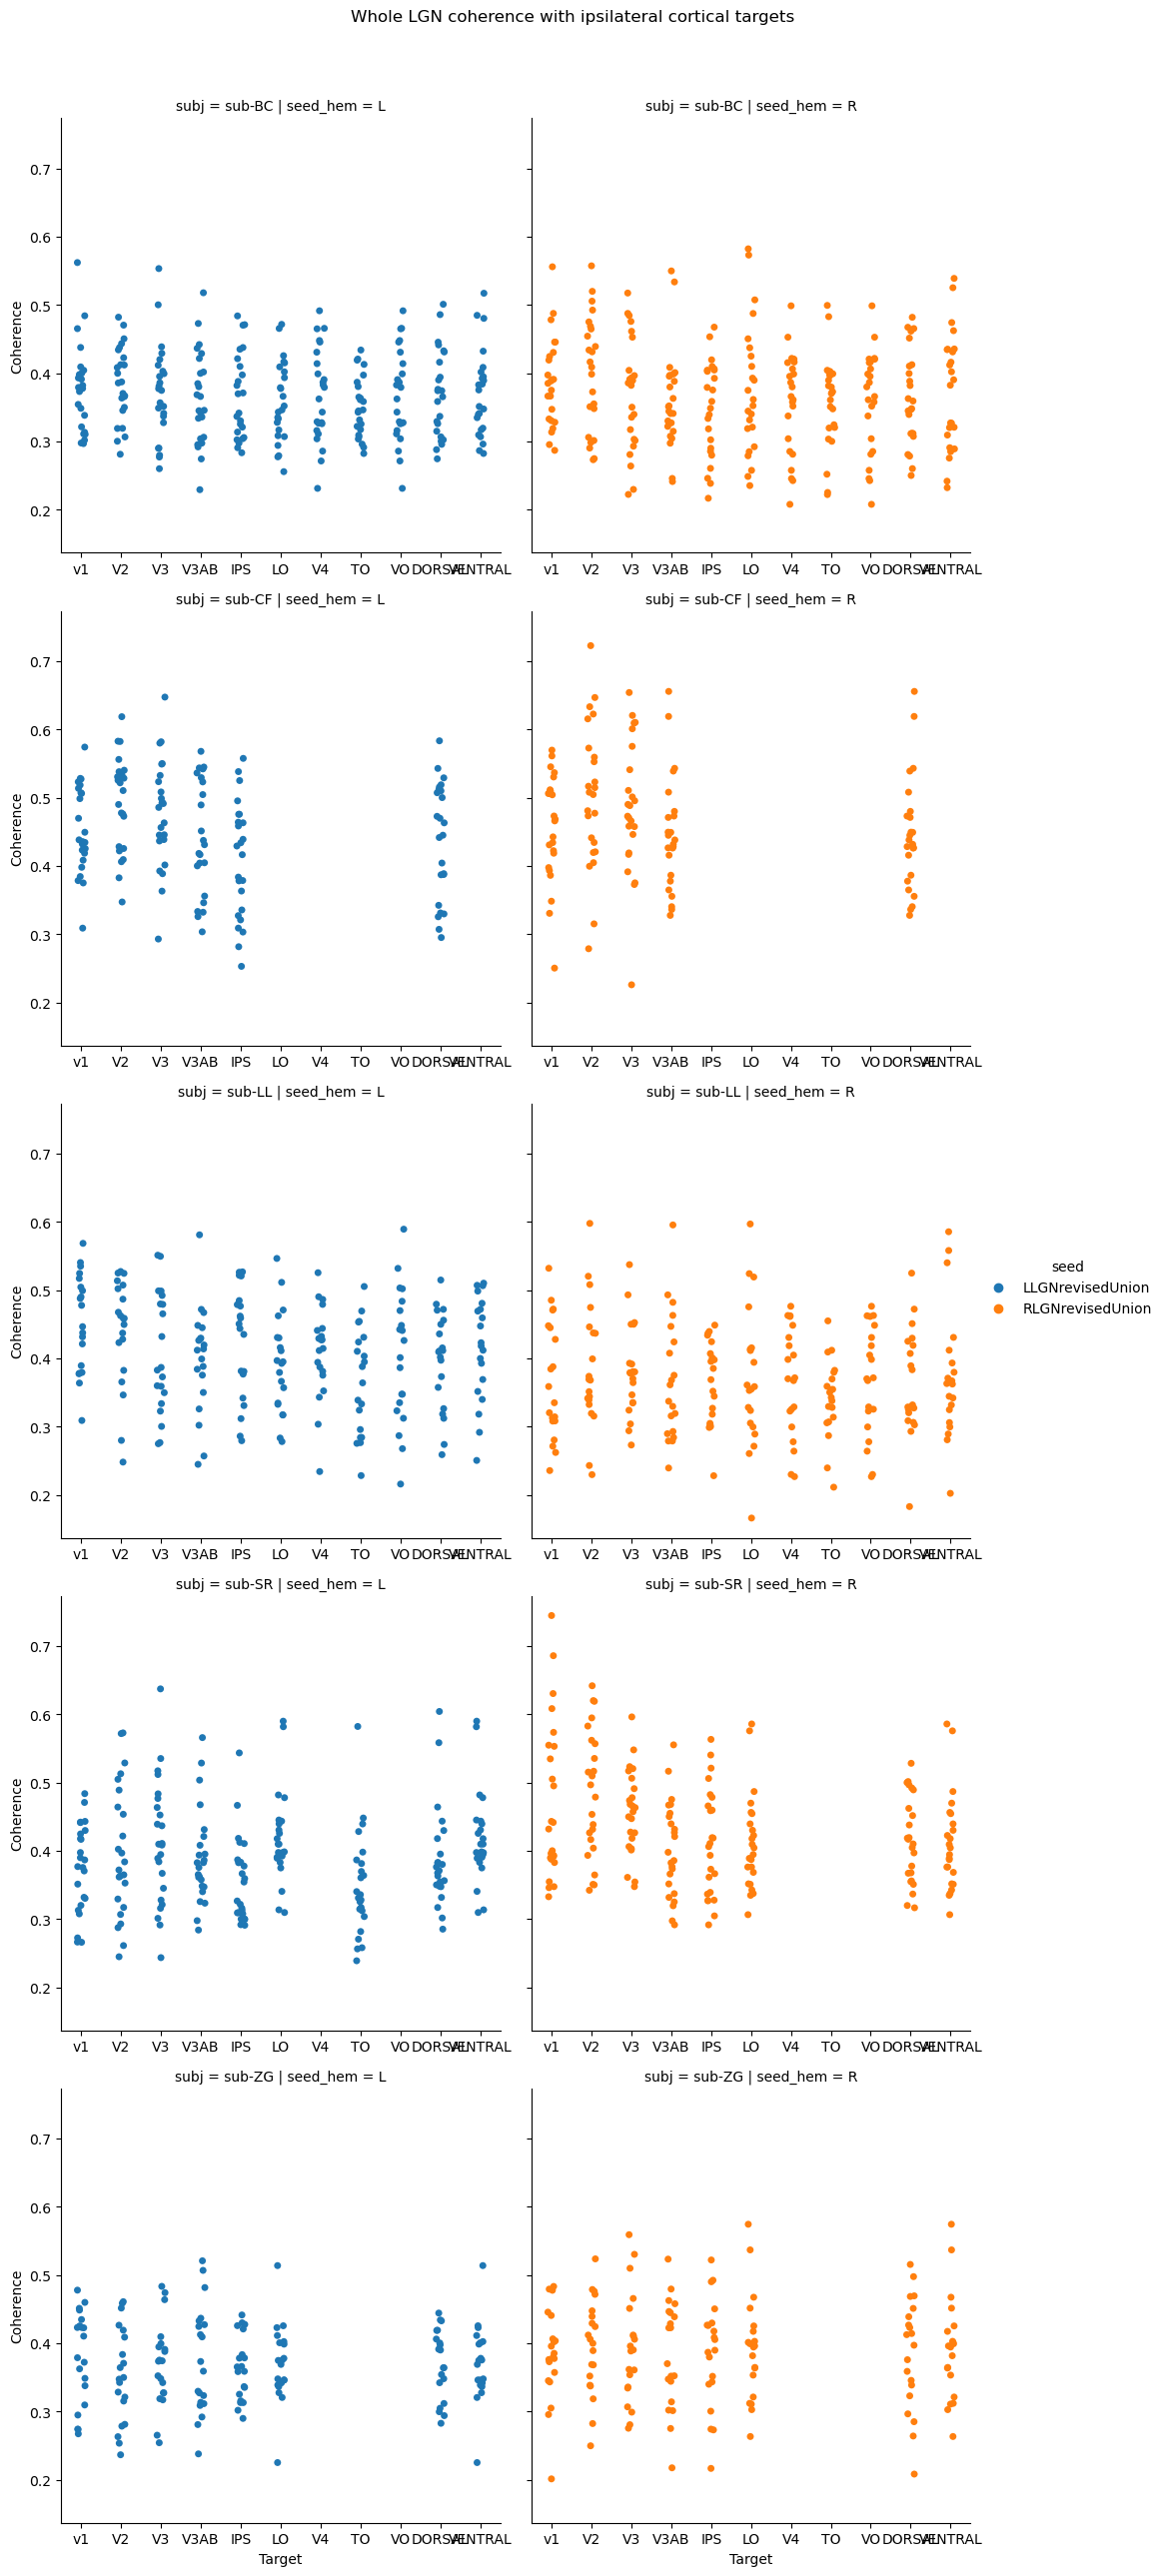

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.catplot(data=df_ipsi_biglgn, kind='strip', x='target_region', y='value', row='subj', hue='seed', col='seed_hem',
            sharex=False, legend=True, order=display_regions).set_axis_labels('Target', "Coherence") \
            .fig.suptitle("Whole LGN coherence with ipsilateral cortical targets", y=1.03)

In [26]:
df_ipsi_biglgn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1960 entries, 576 to 5879
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   subj             1960 non-null   object  
 1   seed             1960 non-null   object  
 2   target           1960 non-null   object  
 3   measurement      1960 non-null   object  
 4   value            1960 non-null   float64 
 5   run              1960 non-null   object  
 6   condition        1960 non-null   object  
 7   bold             1960 non-null   object  
 8   session          1960 non-null   int64   
 9   seed_hem         1960 non-null   object  
 10  seed_region      1960 non-null   object  
 11  target_hem       1960 non-null   object  
 12  target_region    1960 non-null   category
 13  seed_mp          0 non-null      object  
 14  stim_type        1960 non-null   object  
 15  attend_hem       1960 non-null   object  
 16  ipsi_seedtarget  1960 non-null   bool   

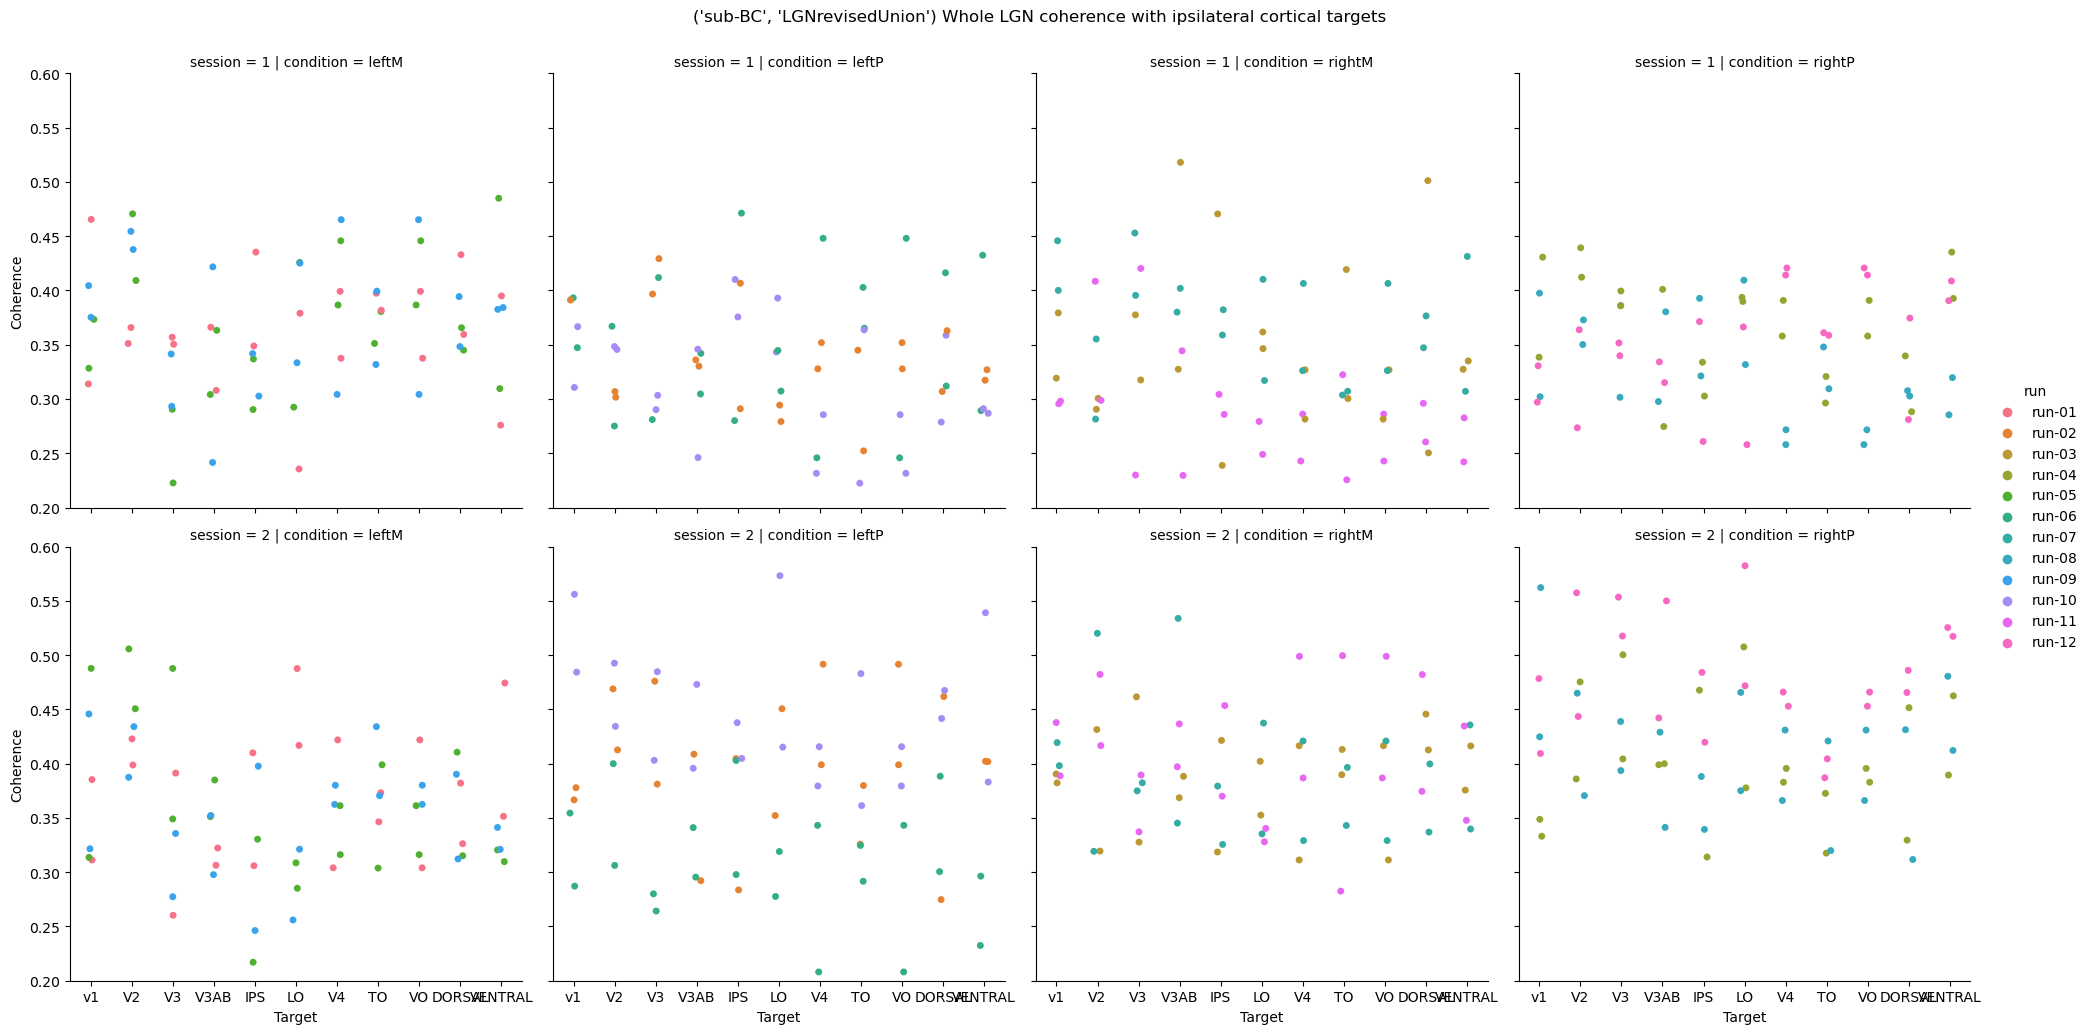

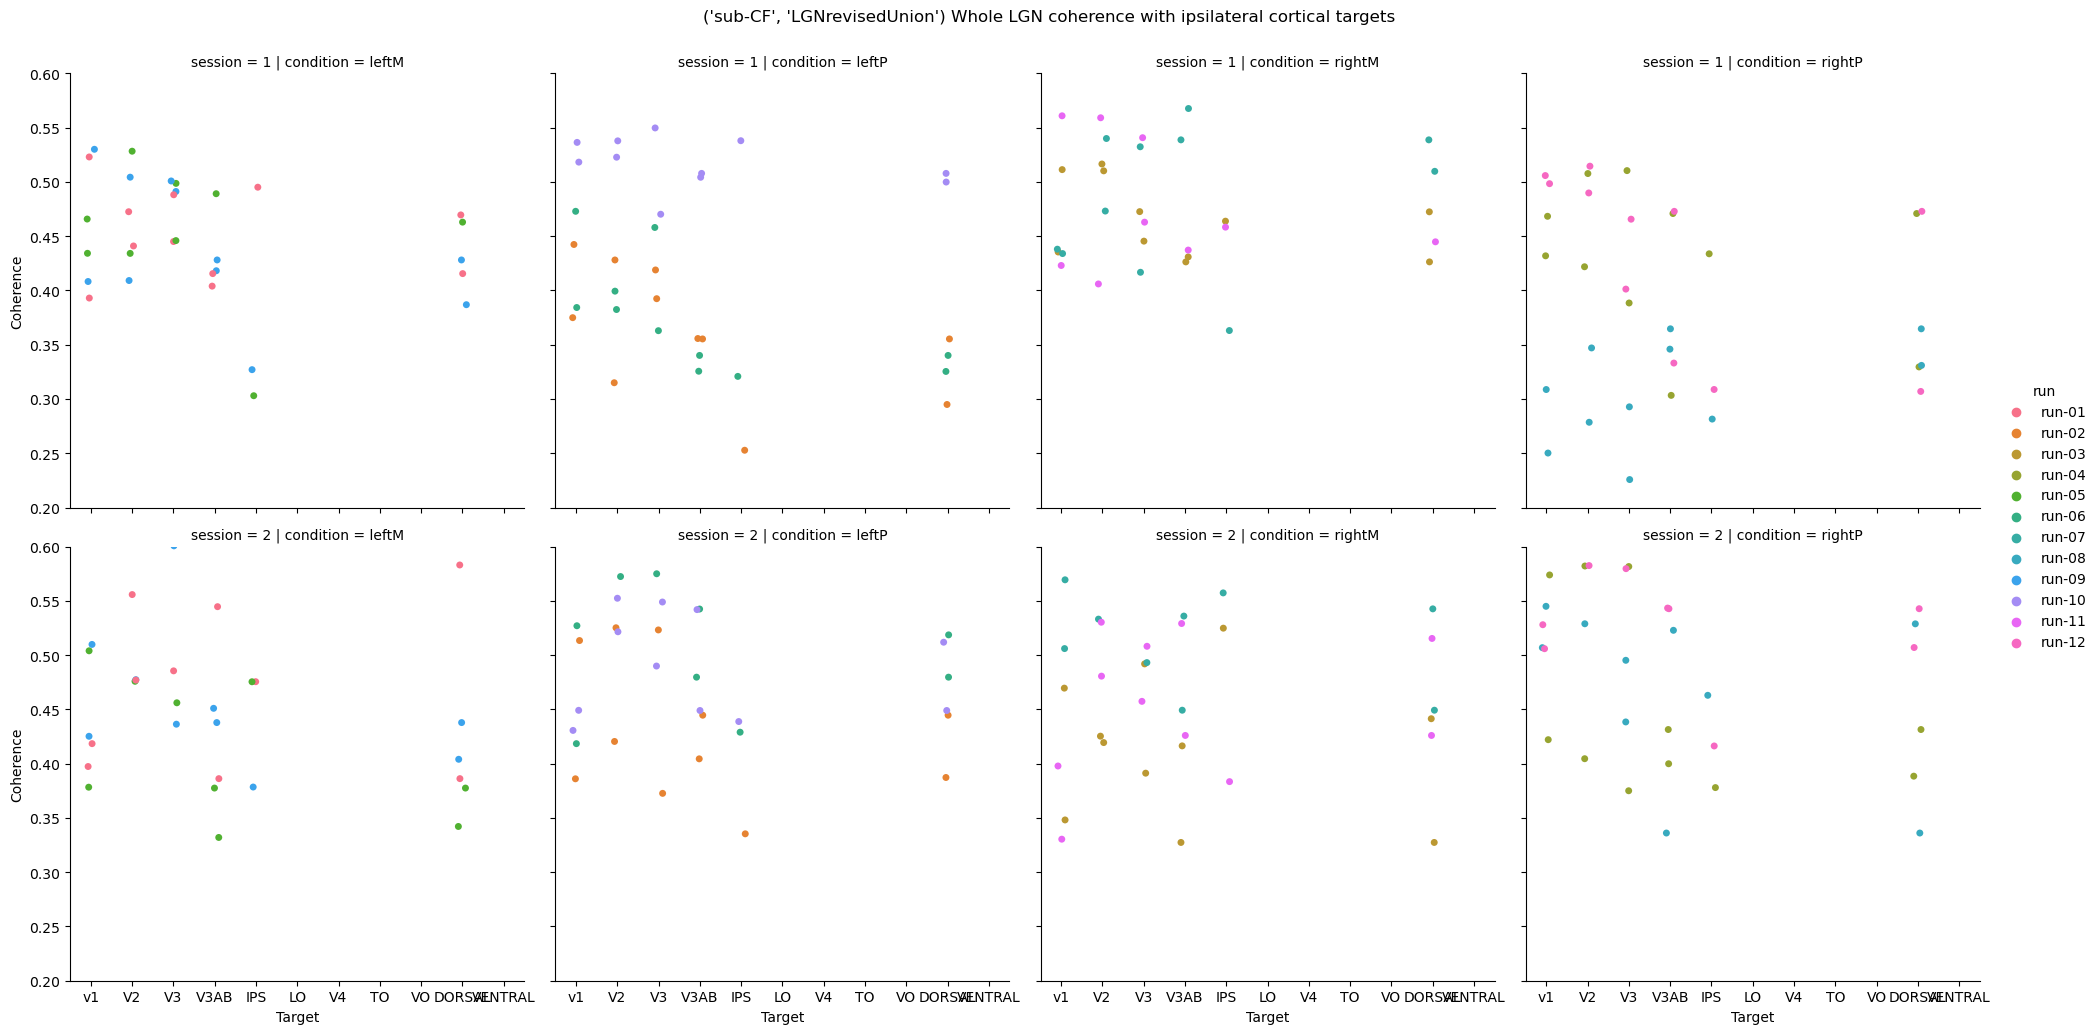

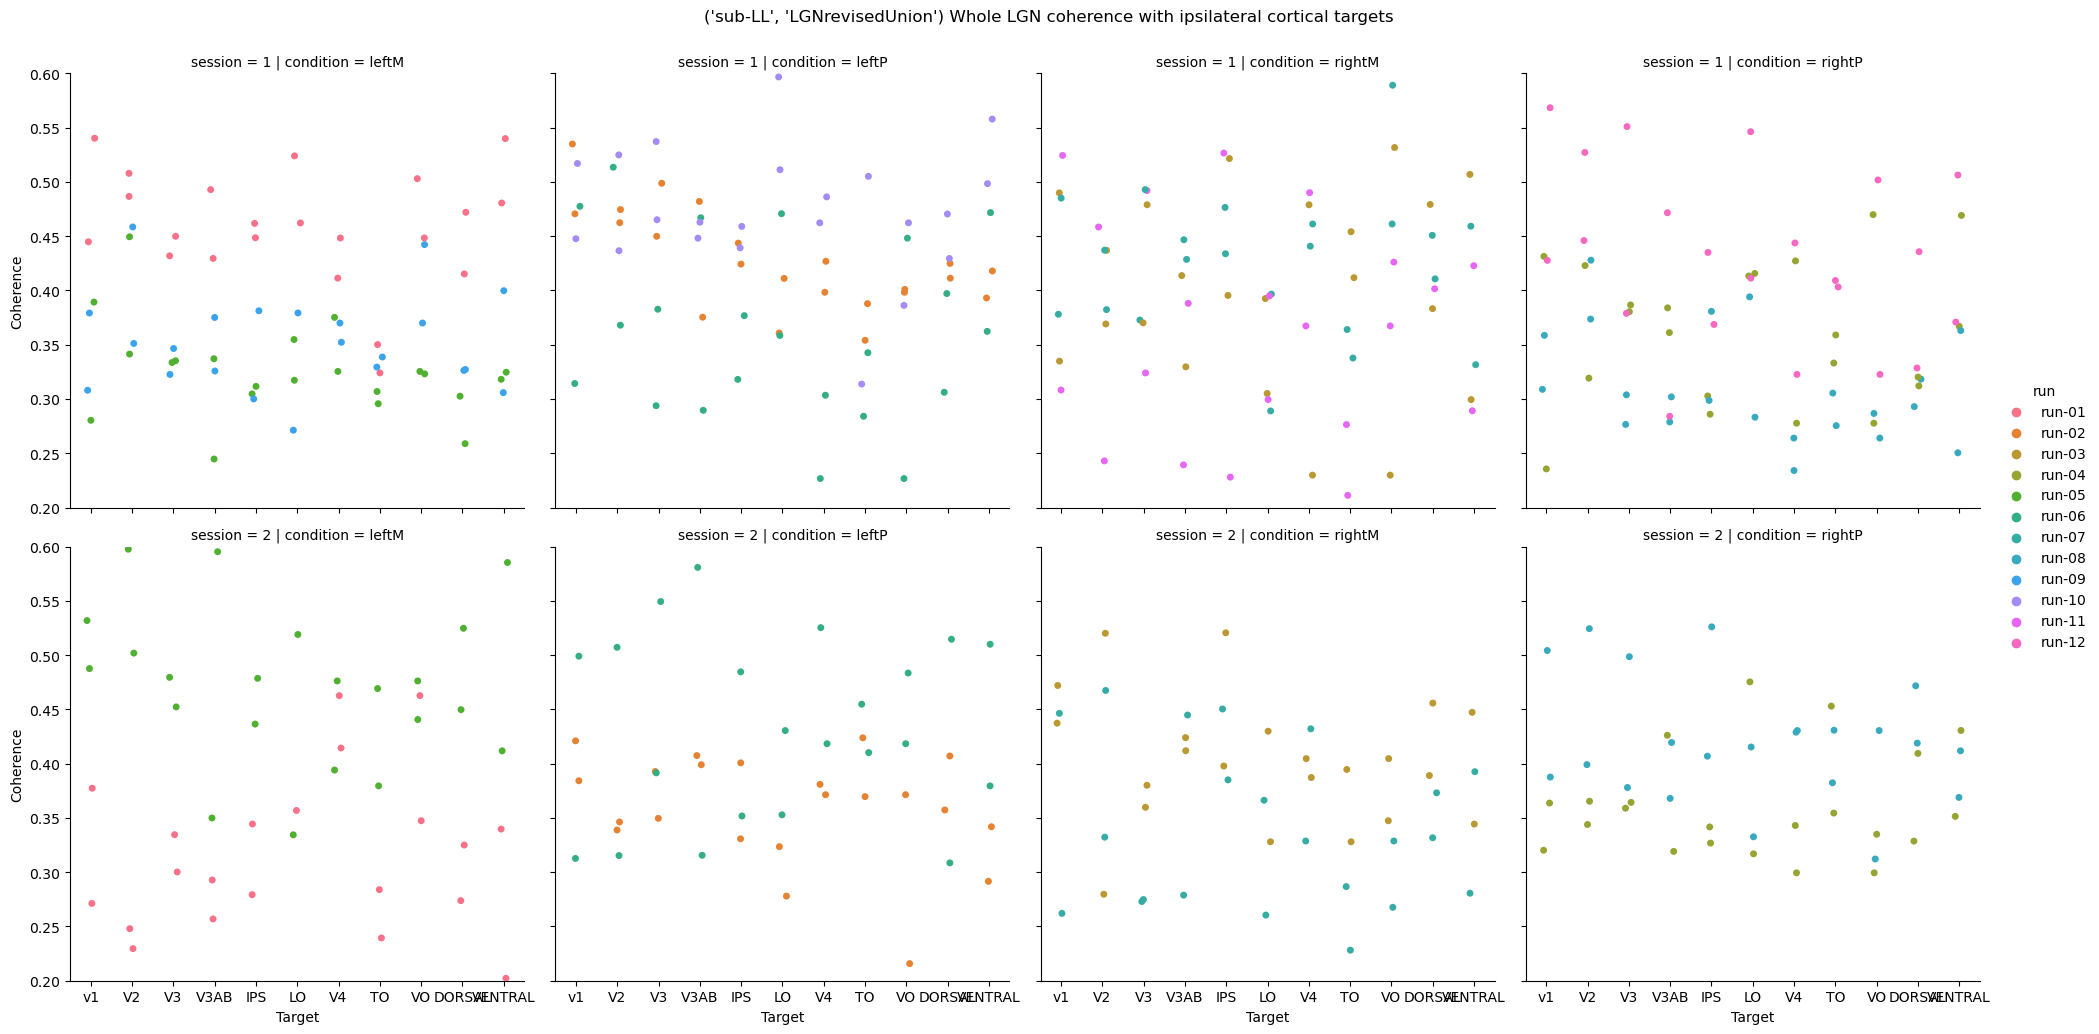

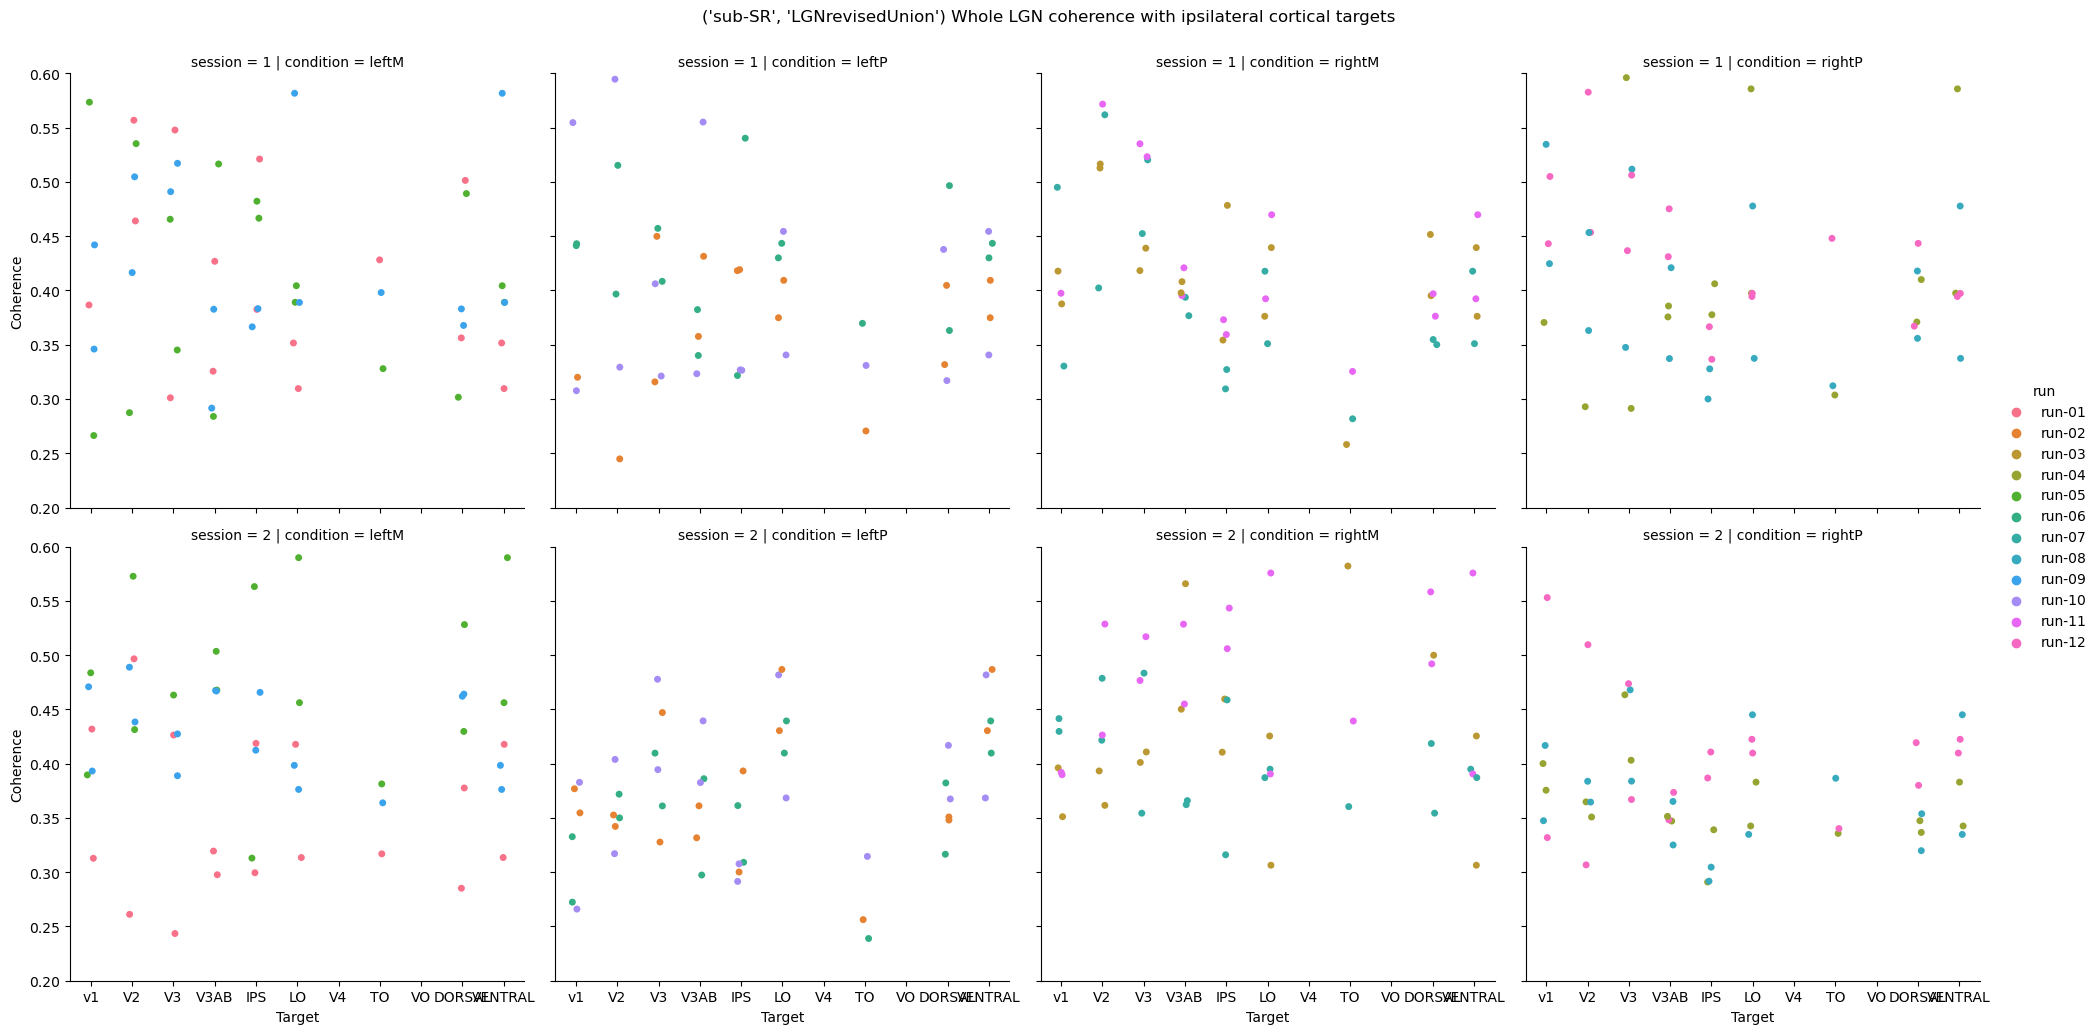

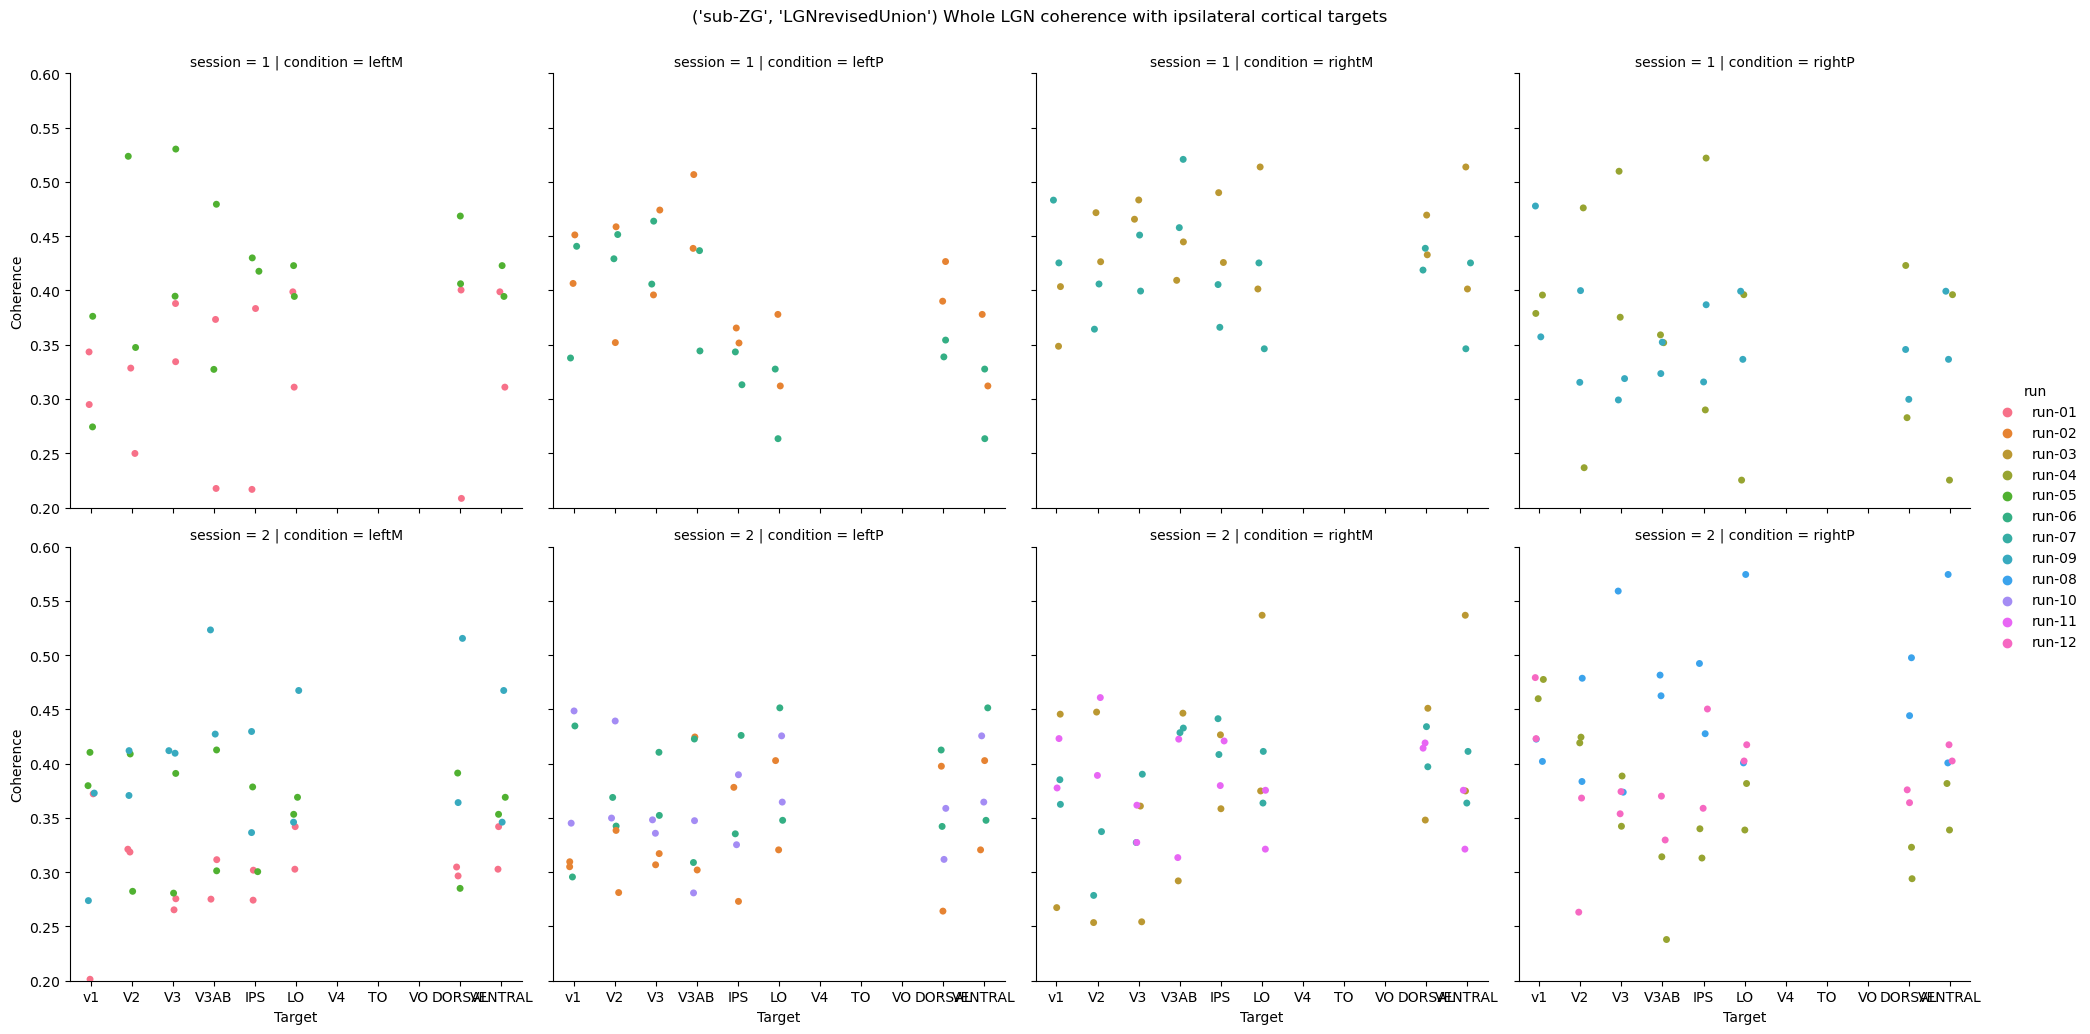

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ylim= (0.2, 0.6)
    for gv, g in df_ipsi_biglgn.groupby(['subj', 'seed_region']):
        sns.catplot(data=g.reset_index(), kind='strip', x='target_region', y='value', row='session',
                    col='condition', hue='run', legend=True, order=display_regions) \
        .set(ylim=ylim)\
        .set_axis_labels('Target', "Coherence") \
        .fig.suptitle(f"{gv} Whole LGN coherence with ipsilateral cortical targets", y=1.03)

In [28]:
gvars_sub_ses = gvars_sub + ['session']
print(gvars_sub_ses)

['subj', 'seed', 'target', 'measurement', 'condition', 'seed_hem', 'seed_region', 'target_hem', 'target_region', 'seed_mp', 'stim_type', 'attend_hem', 'ipsi_seedtarget', 'seed_stim', 'session']


In [29]:
mean_groups = df_ipsi_sublgn.groupby(gvars_sub_ses, observed=True)
print(len(mean_groups))
#for gv, g in mean_groups:
#    print(gv, len(g), np.mean(g['value']), sep='\n')

1408


In [30]:
df_meanrun = mean_groups['value'].agg(['mean','sem'])
# next line renames the columns returned by agg() only since we haven't reset the index yet
df_meanrun.columns = df_meanrun.columns.map(lambda x: f"value_{x}")
df_meanrun = df_meanrun.reset_index()
df_meanrun.head()

,subj,seed,target,measurement,condition,seed_hem,seed_region,target_hem,target_region,seed_mp,stim_type,attend_hem,ipsi_seedtarget,seed_stim,session,value_mean,value_sem
0,sub-BC,LLGNrevisedM90,LDORSAL,coherence,leftM,L,LGNrevisedM90,L,DORSAL,M,M,L,True,True,1,0.353614,0.025746
1,sub-BC,LLGNrevisedM90,LDORSAL,coherence,leftM,L,LGNrevisedM90,L,DORSAL,M,M,L,True,True,2,0.355229,0.027374
2,sub-BC,LLGNrevisedM90,LDORSAL,coherence,leftP,L,LGNrevisedM90,L,DORSAL,M,P,L,True,False,1,0.290234,0.049488
3,sub-BC,LLGNrevisedM90,LDORSAL,coherence,leftP,L,LGNrevisedM90,L,DORSAL,M,P,L,True,False,2,0.329836,0.012863
4,sub-BC,LLGNrevisedM90,LDORSAL,coherence,rightM,L,LGNrevisedM90,L,DORSAL,M,M,R,True,True,1,0.410930,0.059675


In [31]:
display_order = [v for v in df_meanrun.target_region.cat.categories if v in display_regions]

In [32]:
df_meanrun_xatt = df_meanrun.groupby(['subj', 'seed', 'target', 'measurement', 'seed_hem', 'seed_region', 
    'target_hem','target_region','seed_mp', 'stim_type', 'ipsi_seedtarget'], observed=True)['value_mean']\
.agg(['mean', 'sem']).reset_index()


In [33]:
df_meanrun_xatt

,subj,seed,target,measurement,seed_hem,seed_region,target_hem,target_region,seed_mp,stim_type,ipsi_seedtarget,mean,sem
0,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,M,True,0.395829,0.026210
1,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,P,True,0.358835,0.029582
2,sub-BC,LLGNrevisedM90,LIPS,coherence,L,LGNrevisedM90,L,IPS,M,M,True,0.391815,0.025247
3,sub-BC,LLGNrevisedM90,LIPS,coherence,L,LGNrevisedM90,L,IPS,M,P,True,0.355452,0.031266
4,sub-BC,LLGNrevisedM90,LLO,coherence,L,LGNrevisedM90,L,LO,M,M,True,0.351304,0.017844
...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,sub-ZG,RLGNrevisedP40,RV3AB,coherence,R,LGNrevisedP40,R,V3AB,P,P,True,0.389503,0.025402
348,sub-ZG,RLGNrevisedP40,RVENTRAL,coherence,R,LGNrevisedP40,R,VENTRAL,P,M,True,0.395480,0.022572
349,sub-ZG,RLGNrevisedP40,RVENTRAL,coherence,R,LGNrevisedP40,R,VENTRAL,P,P,True,0.397165,0.022441
350,sub-ZG,RLGNrevisedP40,Rv1,coherence,R,LGNrevisedP40,R,v1,P,M,True,0.433396,0.025758


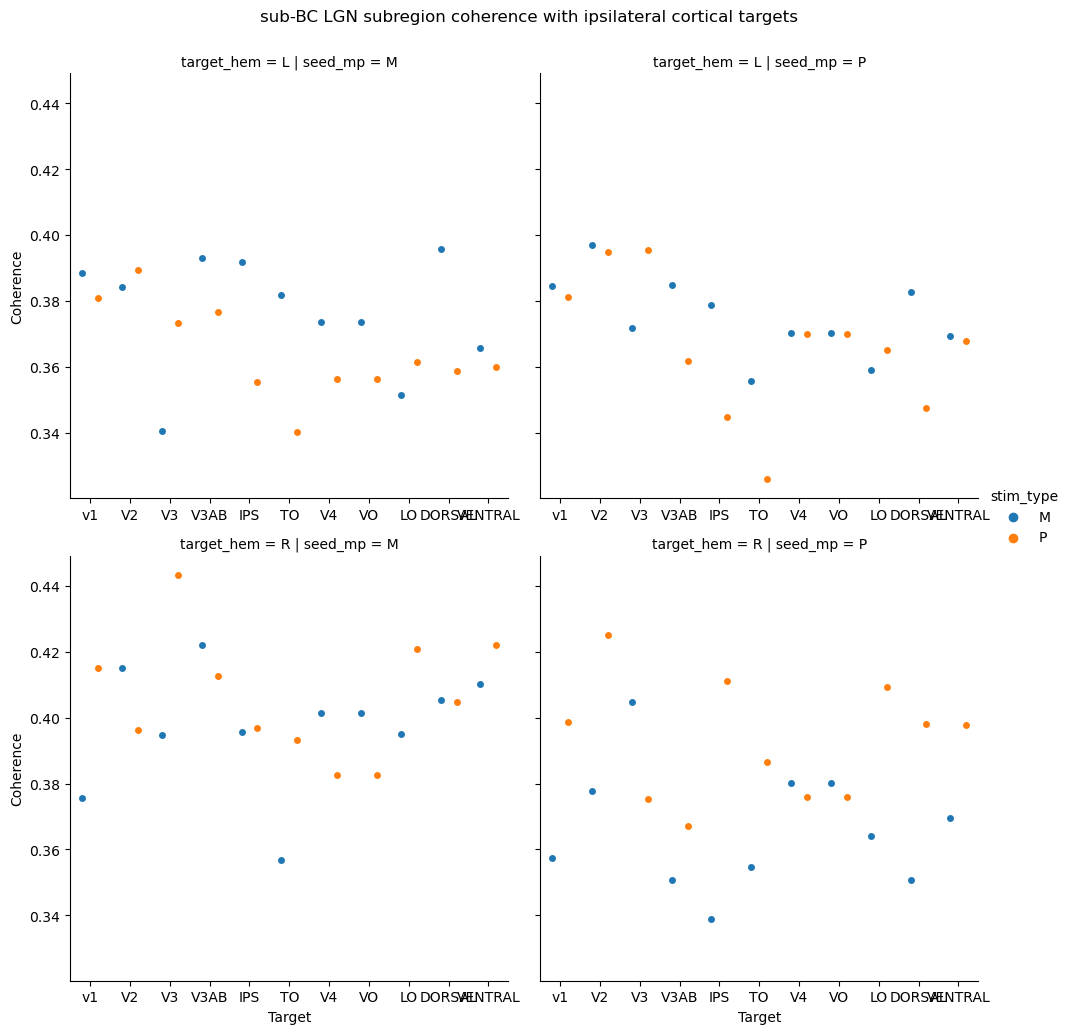

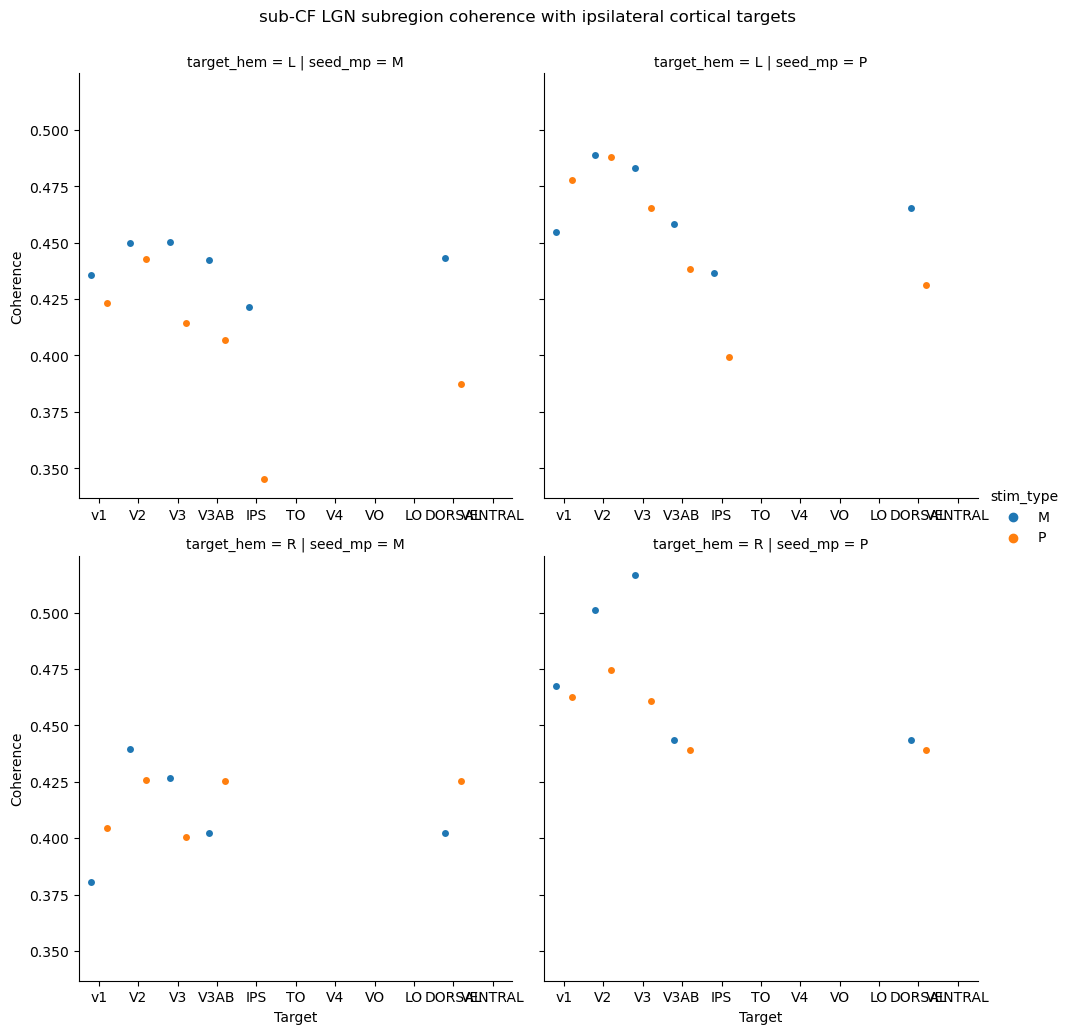

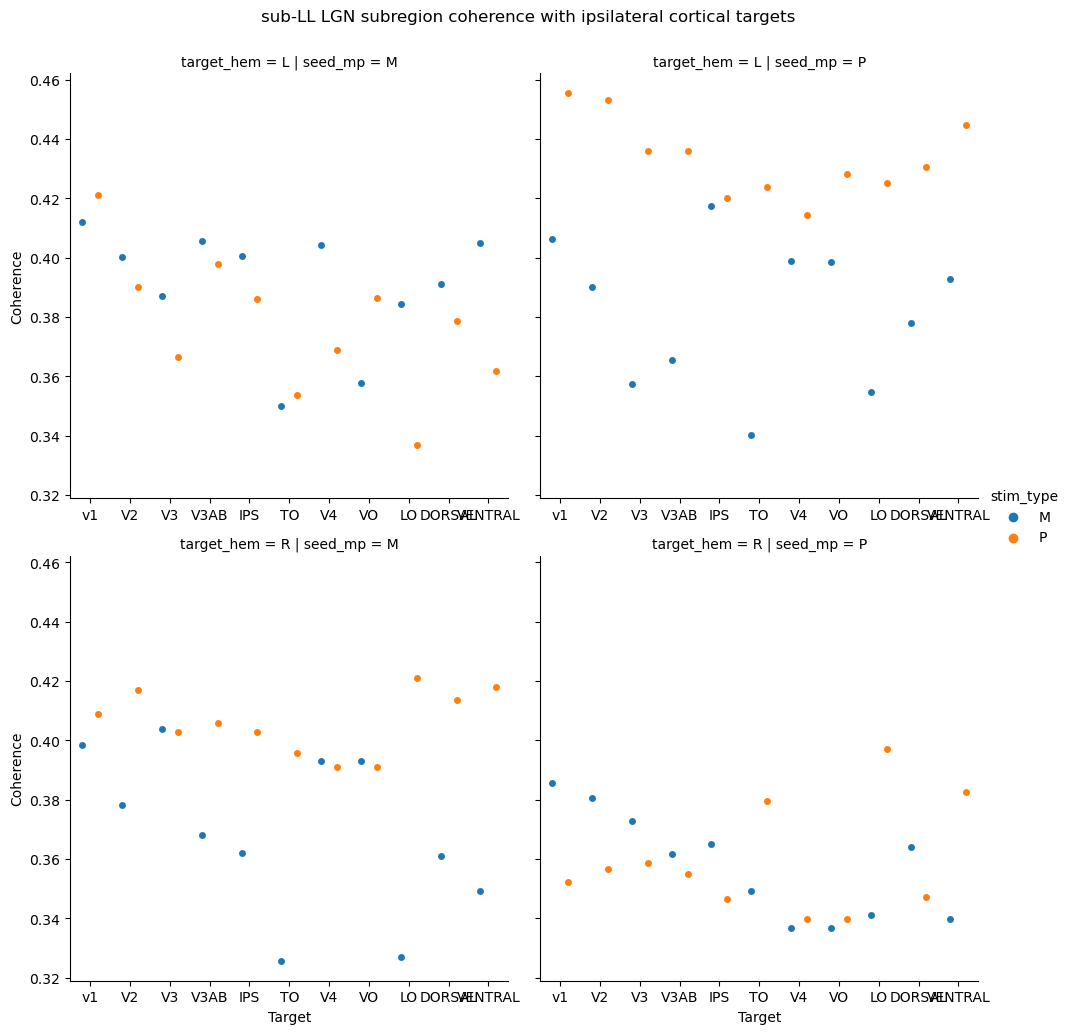

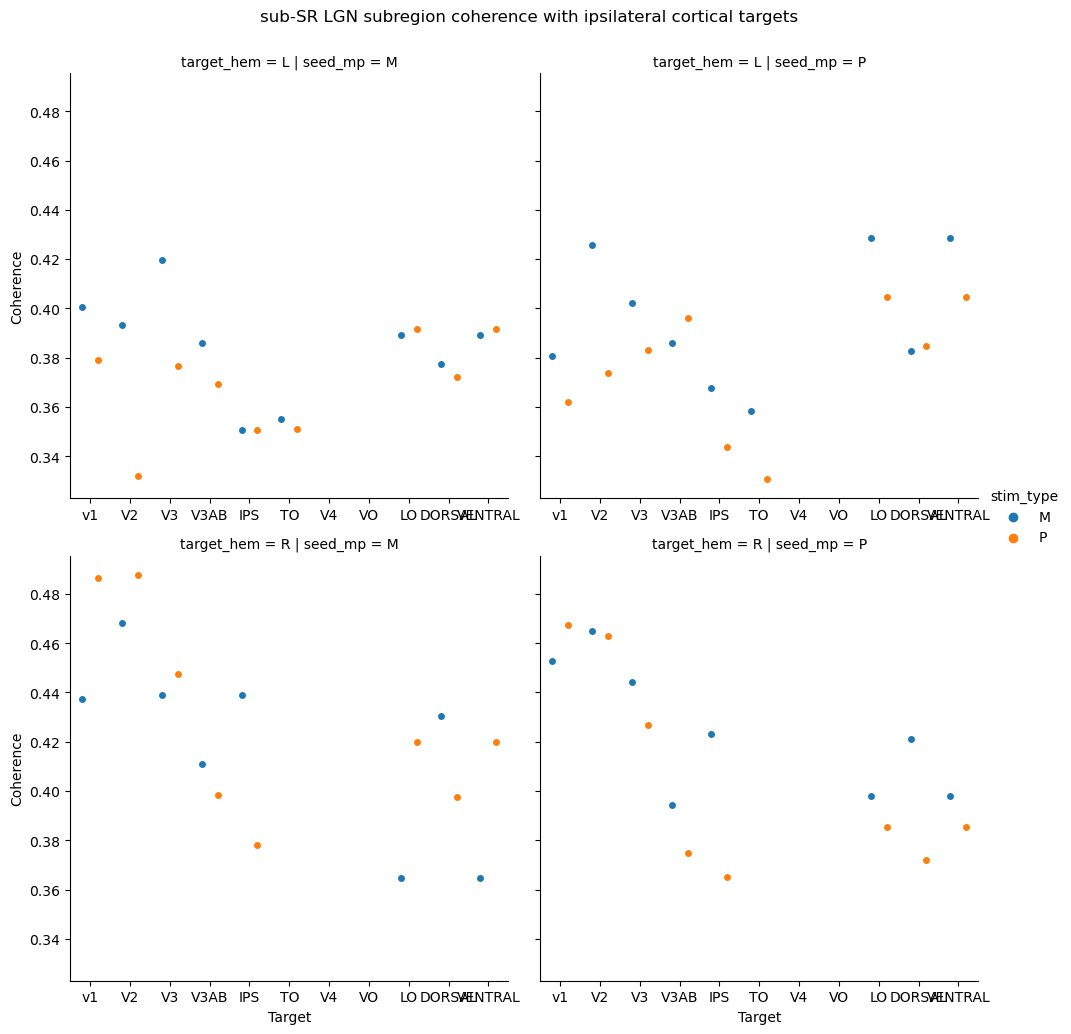

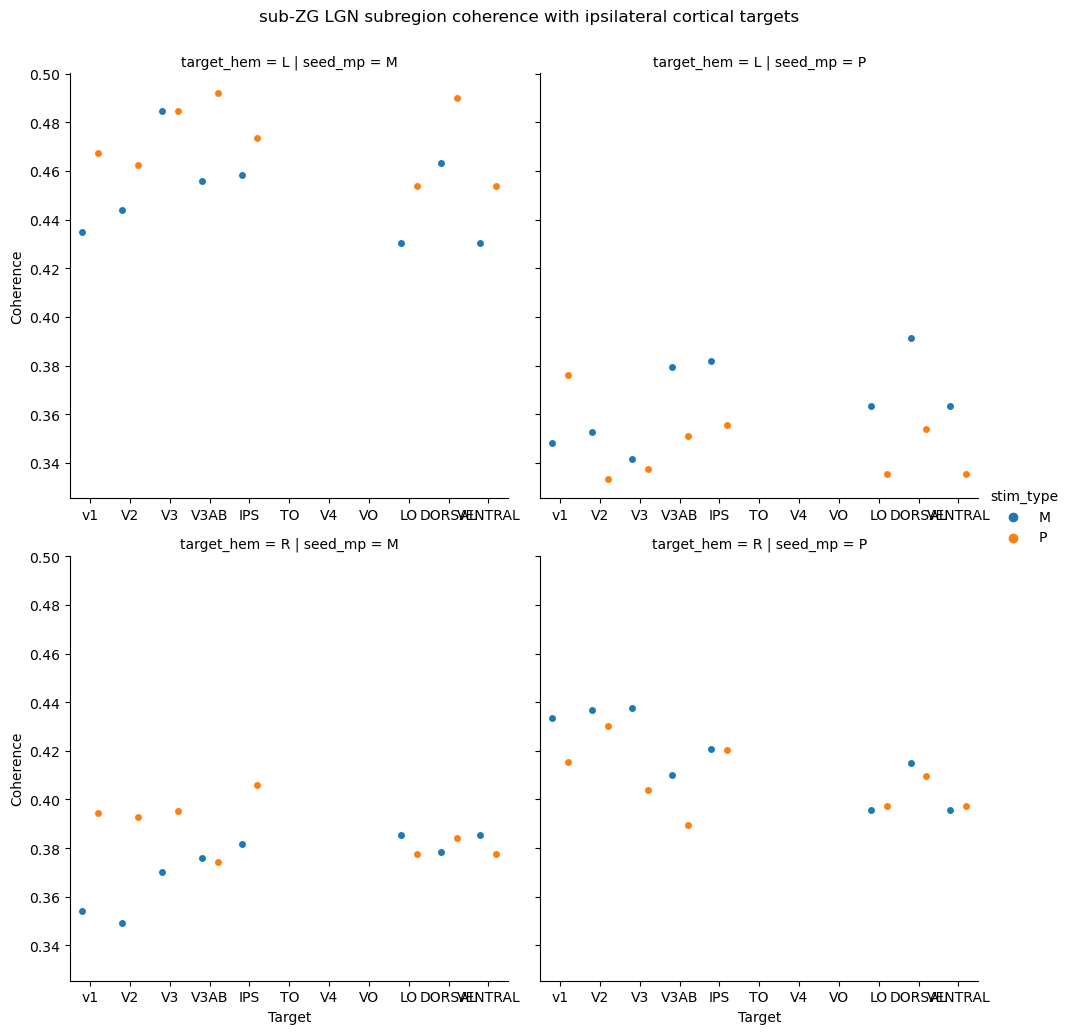

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gv, g in df_meanrun_xatt.groupby(['subj']):
        sns.catplot(data=g.reset_index(), kind='strip', x='target_region', y='mean', col='seed_mp',
                    row='target_hem', hue='stim_type', sharex=False, legend=True, ci=None, dodge=True,
                    order=display_order) \
        .set_axis_labels('Target', "Coherence") \
        .fig.suptitle(f"{gv} LGN subregion coherence with ipsilateral cortical targets", y=1.03)

       subj            seed   target measurement condition seed_hem  \
0    sub-BC  LLGNrevisedM90  LDORSAL   coherence     leftM        L   
1    sub-BC  LLGNrevisedM90  LDORSAL   coherence     leftM        L   
2    sub-BC  LLGNrevisedM90  LDORSAL   coherence     leftP        L   
3    sub-BC  LLGNrevisedM90  LDORSAL   coherence     leftP        L   
4    sub-BC  LLGNrevisedM90  LDORSAL   coherence    rightM        L   
..      ...             ...      ...         ...       ...      ...   
347  sub-BC  RLGNrevisedP40      Rv1   coherence     leftP        R   
348  sub-BC  RLGNrevisedP40      Rv1   coherence    rightM        R   
349  sub-BC  RLGNrevisedP40      Rv1   coherence    rightM        R   
350  sub-BC  RLGNrevisedP40      Rv1   coherence    rightP        R   
351  sub-BC  RLGNrevisedP40      Rv1   coherence    rightP        R   

       seed_region target_hem target_region seed_mp stim_type attend_hem  \
0    LGNrevisedM90          L        DORSAL       M         M          

        subj            seed   target measurement condition seed_hem  \
1152  sub-ZG  LLGNrevisedM90  LDORSAL   coherence     leftM        L   
1153  sub-ZG  LLGNrevisedM90  LDORSAL   coherence     leftM        L   
1154  sub-ZG  LLGNrevisedM90  LDORSAL   coherence     leftP        L   
1155  sub-ZG  LLGNrevisedM90  LDORSAL   coherence     leftP        L   
1156  sub-ZG  LLGNrevisedM90  LDORSAL   coherence    rightM        L   
...      ...             ...      ...         ...       ...      ...   
1403  sub-ZG  RLGNrevisedP40      Rv1   coherence     leftP        R   
1404  sub-ZG  RLGNrevisedP40      Rv1   coherence    rightM        R   
1405  sub-ZG  RLGNrevisedP40      Rv1   coherence    rightM        R   
1406  sub-ZG  RLGNrevisedP40      Rv1   coherence    rightP        R   
1407  sub-ZG  RLGNrevisedP40      Rv1   coherence    rightP        R   

        seed_region target_hem target_region seed_mp stim_type attend_hem  \
1152  LGNrevisedM90          L        DORSAL       M      

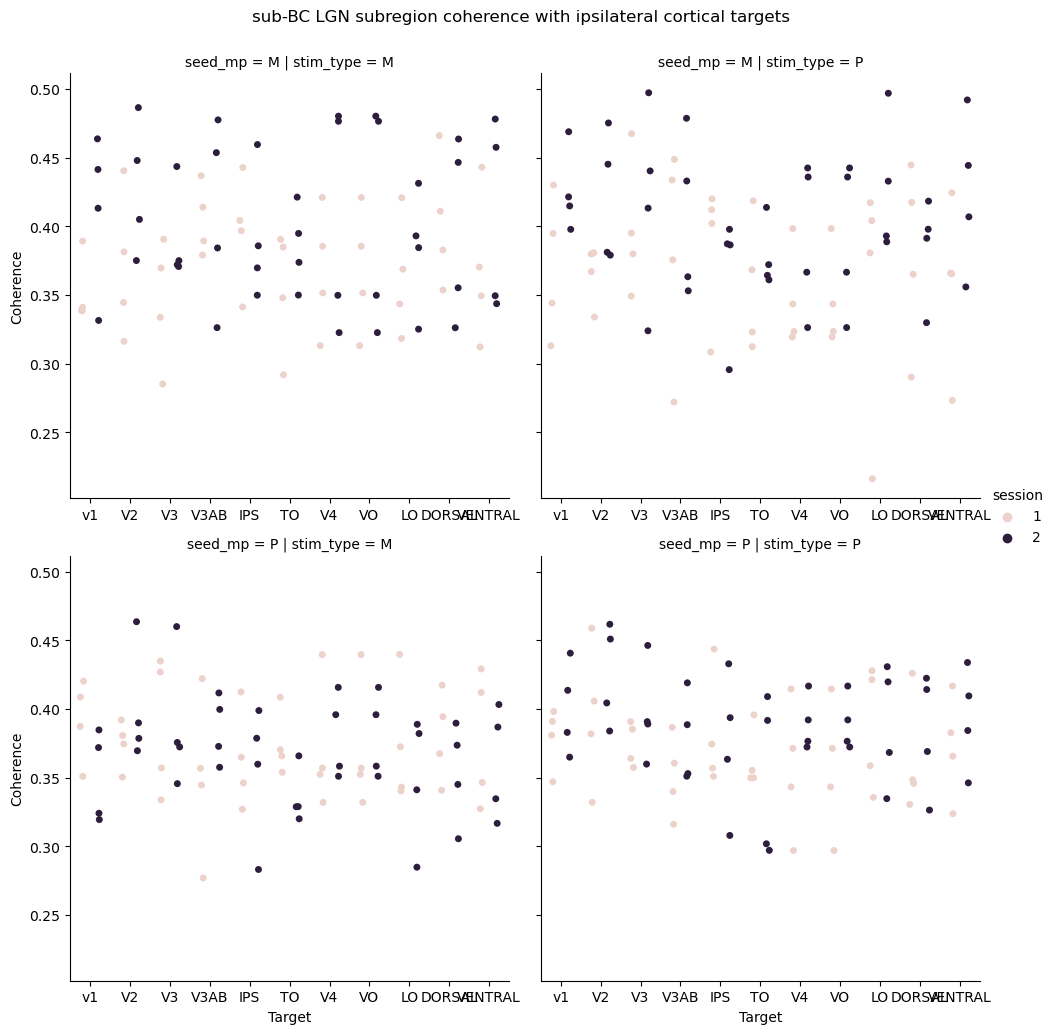

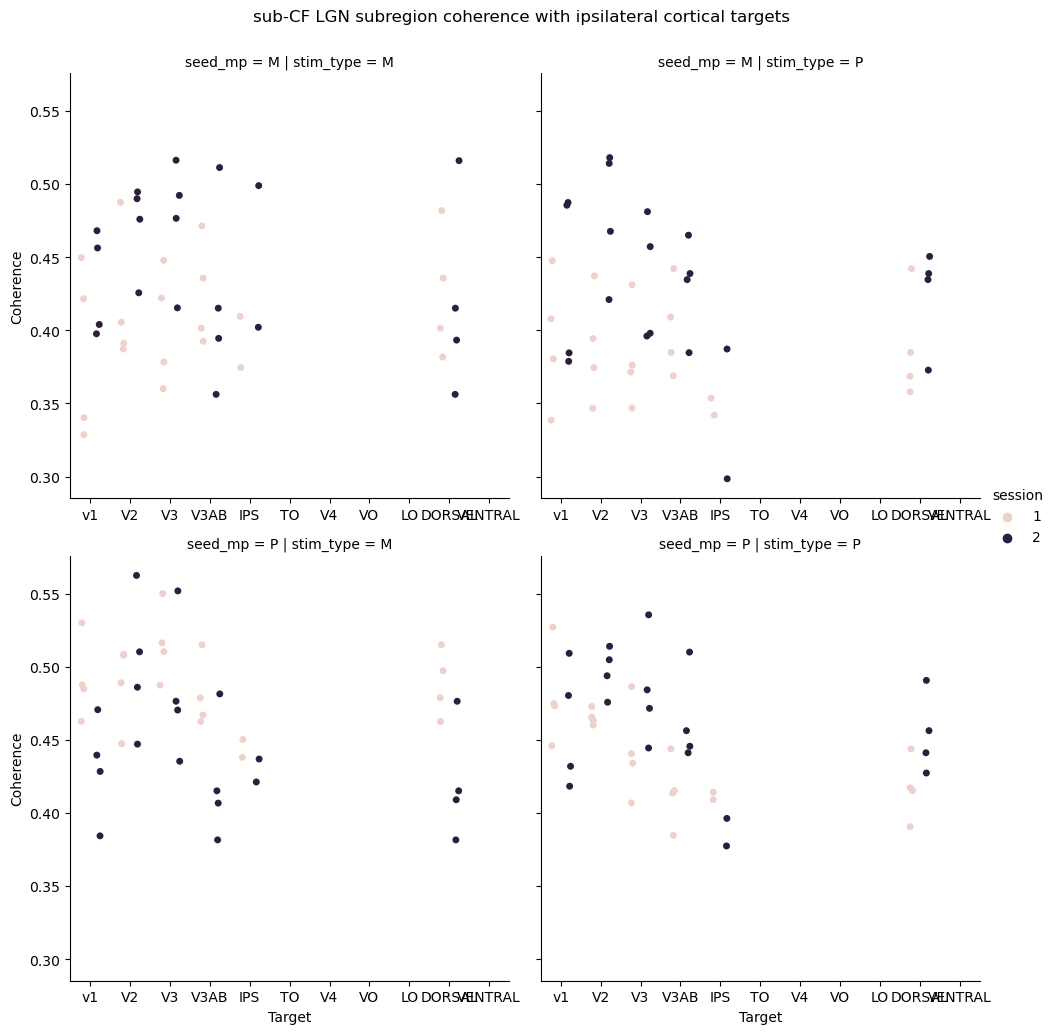

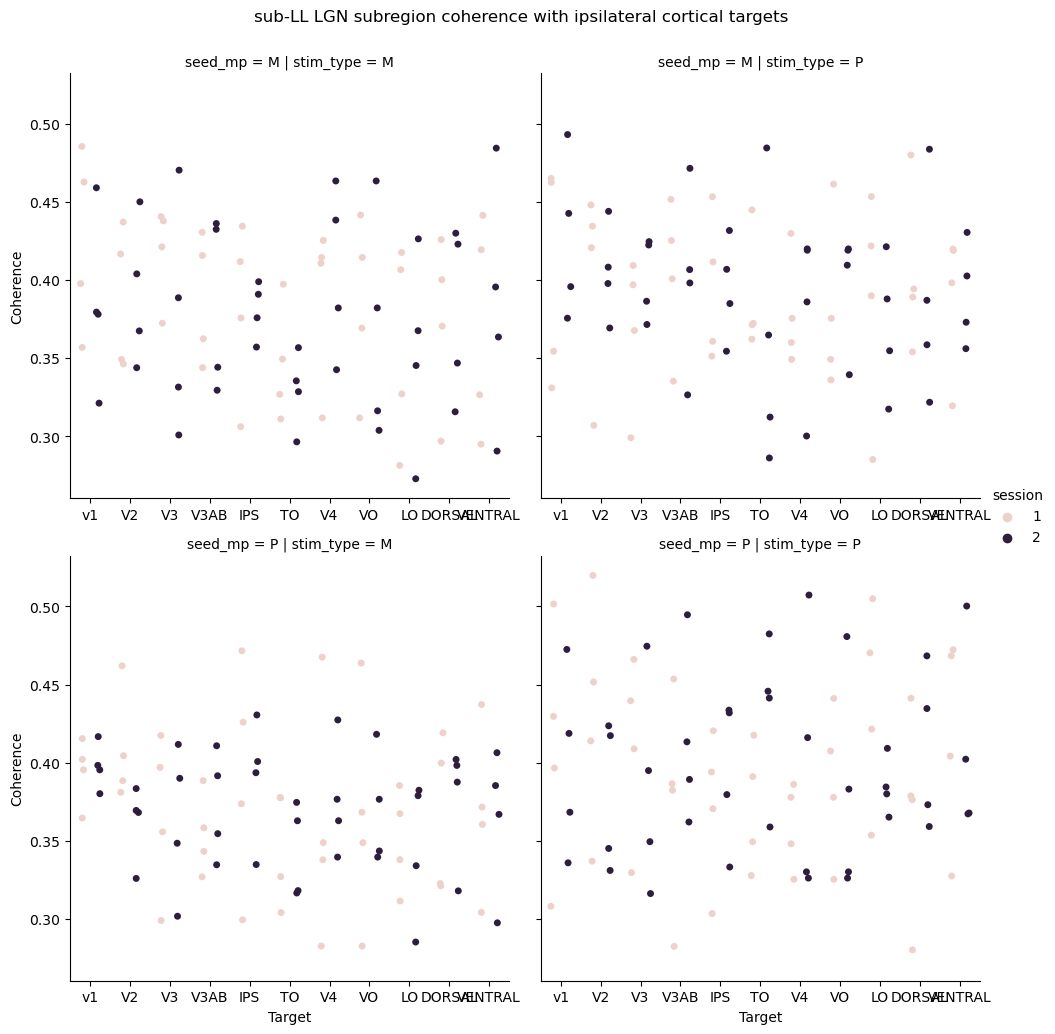

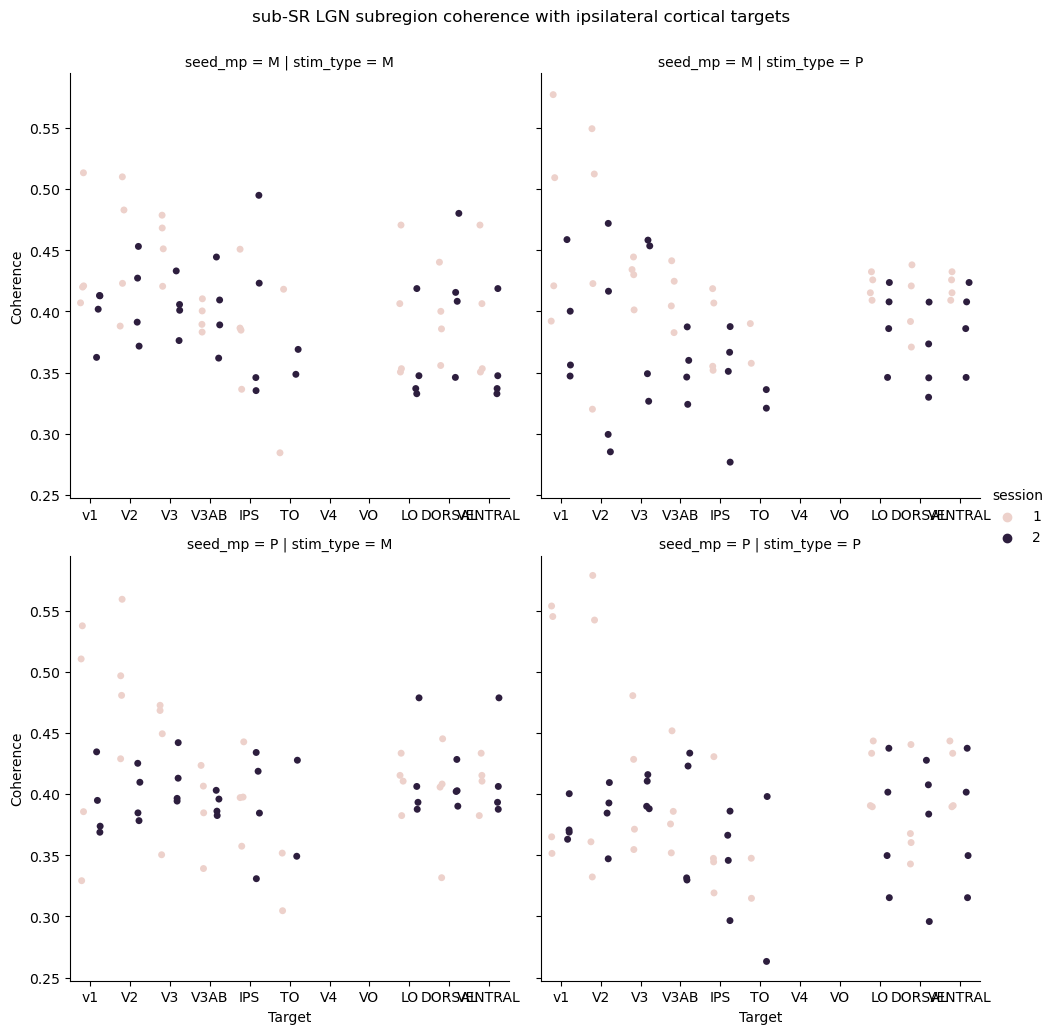

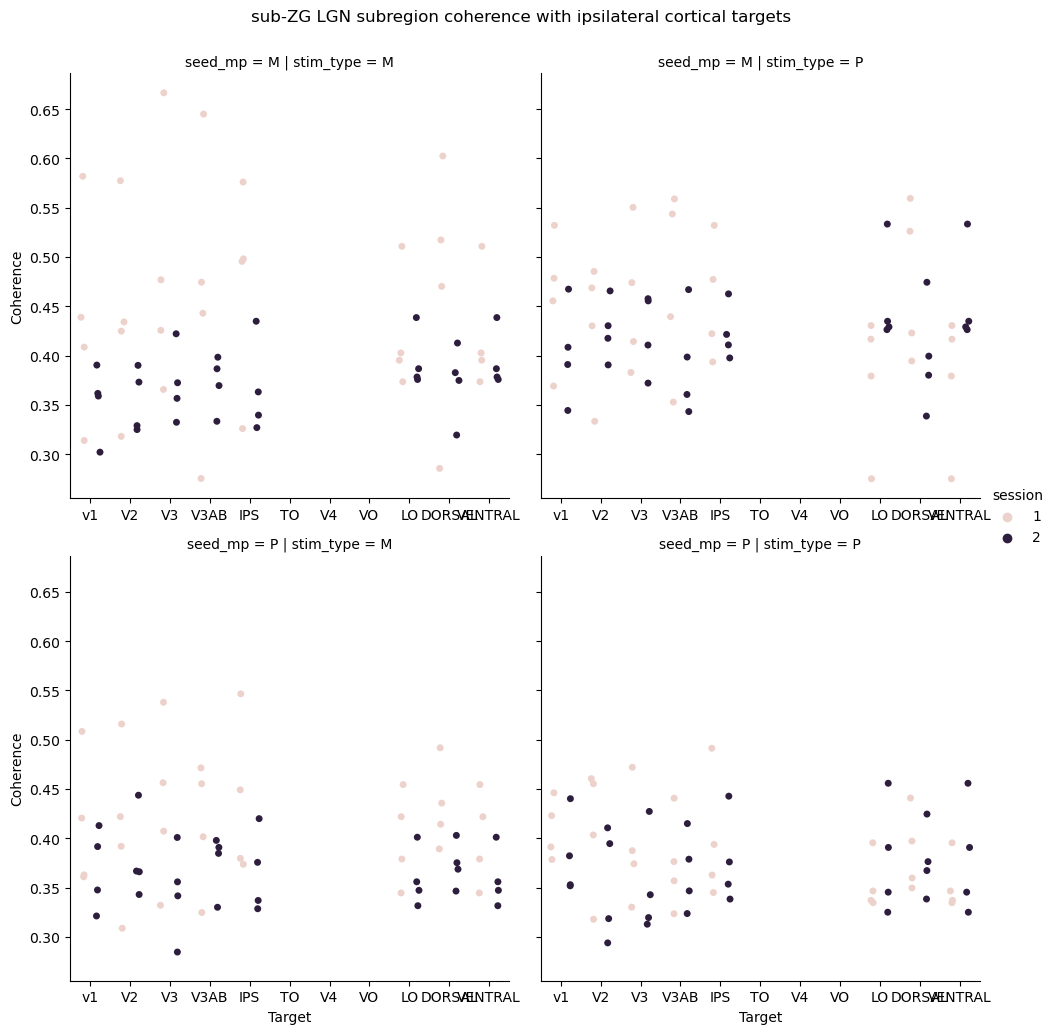

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gv, g in df_meanrun.groupby(['subj']):
        print(g)
        sns.catplot(data=g.reset_index(), kind='strip', x='target_region', y='value_mean', row='seed_mp',
                    col='stim_type', hue='session', sharex=False, legend=True, ci=None, dodge=True,
                    order=display_order) \
        .set_axis_labels('Target', "Coherence") \
        .fig.suptitle(f"{gv} LGN subregion coherence with ipsilateral cortical targets", y=1.03)

## M-stim - P-stim contrasts (over different values of stim_type)

In [36]:
id_cols

['subj', 'seed', 'target', 'measurement', 'condition']

In [37]:
constructed_cols

['seed_hem',
 'seed_region',
 'target_hem',
 'target_region',
 'seed_mp',
 'stim_type',
 'attend_hem',
 'ipsi_seedtarget',
 'seed_stim']

In [38]:
df_meanrun.target_region.cat.categories

Index(['v1', 'V2', 'V3', 'V3AB', 'IPS', 'TO', 'V4', 'VO', 'LO', 'DORSAL',
       'VENTRAL', 'v2d', 'v2v', 'v3d', 'v3v', 'v4', 'ips0', 'ips1', 'ips2',
       'ips3', 'ips4', 'ips5', 'lo1', 'lo2', 'to1', 'to2', 'vo1', 'vo2'],
      dtype='object')

In [39]:
mp_contrast_cols = ['subj', 'seed', 'target', 'measurement', 'seed_hem', 'seed_region', 
                   'target_hem','target_region','seed_mp', 'attend_hem', 'ipsi_seedtarget']
mp_xatt_cols = list(set(mp_contrast_cols).difference(['attend_hem']))
mp_xseed_cols = list(set(mp_contrast_cols).difference(['seed', 'seed_hem', 'seed_region', 'seed_mp']))

In [40]:
mp_xseed_cols

['measurement',
 'target_hem',
 'attend_hem',
 'target_region',
 'target',
 'ipsi_seedtarget',
 'subj']

In [41]:
def mp_diff(df):
    #print(df)
    assert(len(df)==2)
    m = df[df.stim_type=='M']['value_mean']
    assert(len(m)==1)
    p = df[df.stim_type=='P']['value_mean']
    assert(len(p)==1)
    #print(m, p)
    diff = m.iloc[0] - p.iloc[0]
    #print(diff)
    return pd.Series({'mp_diff': diff})

def mp_seed_diff(df):
    #print(df)
    assert(len(df)==2)
    m = df[df.seed_mp=='M']['mp_mean']
    assert(len(m)==1)
    p = df[df.seed_mp=='P']['mp_mean']
    assert(len(p)==1)
    #print(m, p)
    diff = m.iloc[0] - p.iloc[0]
    #print(diff)
    return pd.Series({'mp_seed_diff': diff})

In [42]:
len(df_meanrun)

1408

In [43]:
df_meanrun.groupby(mp_contrast_cols + ['session'], observed=True).describe()

value_mean  \
                                                                                                                                           count   
subj   seed           target   measurement seed_hem seed_region   target_hem target_region seed_mp attend_hem ipsi_seedtarget session              
sub-BC LLGNrevisedM90 LDORSAL  coherence   L        LGNrevisedM90 L          DORSAL        M       L          True            1              2.0   
                                                                                                                              2              2.0   
                                                                                                   R          True            1              2.0   
                                                                                                                              2              2.0   
                      LIPS     coherence   L        LGNrevisedM90 L          IPS           M       L          True            1              2.0   
...                                                                                                                                          ...   
sub-ZG RLGNrevisedP40 RVENTRAL coherence   R        LGNrevisedP40 R          VENTRAL       P       R          True            2              2.0   
                      Rv1      coherence   R        LGNrevisedP40 R          v1            P       L          True            1              2.0   
                                                                                                                              2              2.0   
                                                                                                   R          True            1              2.0   
                                                                                                                              2              2.0   

                                                                                                                                                 \
                                                                                                                                           mean   
subj   seed           target   measurement seed_hem seed_region   target_hem target_region seed_mp attend_hem ipsi_seedtarget session             
sub-BC LLGNrevisedM90 LDORSAL  coherence   L        LGNrevisedM90 L          DORSAL        M       L          True            1        0.321924   
                                                                                                                              2        0.342533   
                                                                                                   R          True            1        0.414167   
                                                                                                                              2        0.430705   
                      LIPS     coherence   L        LGNrevisedM90 L          IPS           M       L          True            1        0.324880   
...                                                                                                                                         ...   
sub-ZG RLGNrevisedP40 RVENTRAL coherence   R        LGNrevisedP40 R          VENTRAL       P       R          True            2        0.428491   
                      Rv1      coherence   R        LGNrevisedP40 R          v1            P       L          True            1        0.433363   
                                                                                                                              2        0.382940   
                                                                                                   R          True            1        0.465731   
                                                                                                                              2        0.415923   

  

In [44]:
mp_groups = df_meanrun.groupby(mp_contrast_cols + ['session'], observed=True)
print(len(mp_groups))
mp_diffs = mp_groups.apply(mp_diff).reset_index()

704


In [45]:
mp_diffs

,subj,seed,target,measurement,seed_hem,seed_region,target_hem,target_region,seed_mp,attend_hem,ipsi_seedtarget,session,mp_diff
0,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,L,True,1,0.063380
1,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,L,True,2,0.025393
2,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,R,True,1,-0.006474
3,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,R,True,2,0.065675
4,sub-BC,LLGNrevisedM90,LIPS,coherence,L,LGNrevisedM90,L,IPS,M,L,True,1,0.032803
...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,sub-ZG,RLGNrevisedP40,RVENTRAL,coherence,R,LGNrevisedP40,R,VENTRAL,P,R,True,2,-0.054721
700,sub-ZG,RLGNrevisedP40,Rv1,coherence,R,LGNrevisedP40,R,v1,P,L,True,1,-0.025588
701,sub-ZG,RLGNrevisedP40,Rv1,coherence,R,LGNrevisedP40,R,v1,P,L,True,2,0.059959
702,sub-ZG,RLGNrevisedP40,Rv1,coherence,R,LGNrevisedP40,R,v1,P,R,True,1,0.085451


In [46]:
mp_diffs.groupby(mp_contrast_cols, observed=True)['mp_diff'].mean().reset_index()

,subj,seed,target,measurement,seed_hem,seed_region,target_hem,target_region,seed_mp,attend_hem,ipsi_seedtarget,mp_diff
0,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,L,True,0.044387
1,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,R,True,0.029601
2,sub-BC,LLGNrevisedM90,LIPS,coherence,L,LGNrevisedM90,L,IPS,M,L,True,0.053444
3,sub-BC,LLGNrevisedM90,LIPS,coherence,L,LGNrevisedM90,L,IPS,M,R,True,0.019283
4,sub-BC,LLGNrevisedM90,LLO,coherence,L,LGNrevisedM90,L,LO,M,L,True,0.042373
...,...,...,...,...,...,...,...,...,...,...,...,...
347,sub-ZG,RLGNrevisedP40,RV3AB,coherence,R,LGNrevisedP40,R,V3AB,P,R,True,0.057399
348,sub-ZG,RLGNrevisedP40,RVENTRAL,coherence,R,LGNrevisedP40,R,VENTRAL,P,L,True,-0.005543
349,sub-ZG,RLGNrevisedP40,RVENTRAL,coherence,R,LGNrevisedP40,R,VENTRAL,P,R,True,0.002174
350,sub-ZG,RLGNrevisedP40,Rv1,coherence,R,LGNrevisedP40,R,v1,P,L,True,0.017185


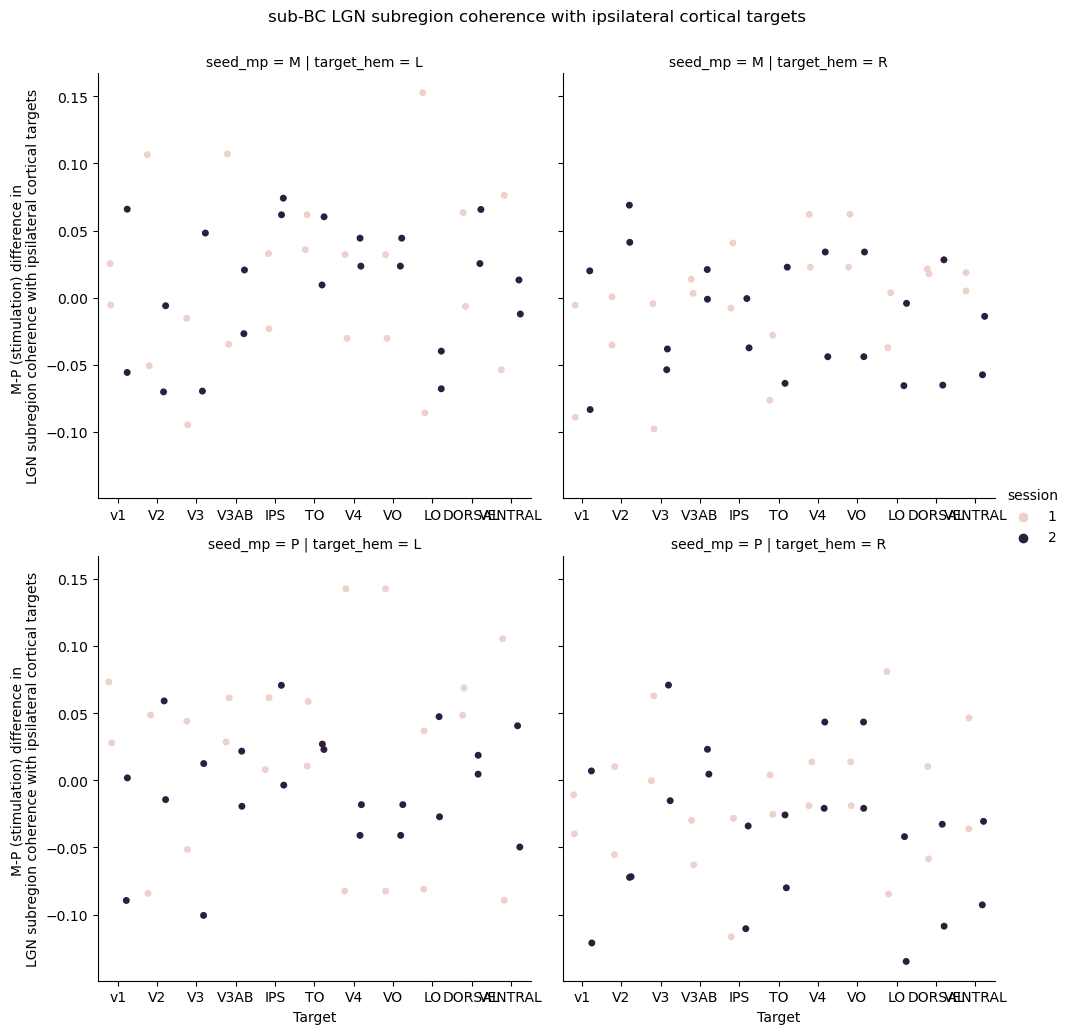

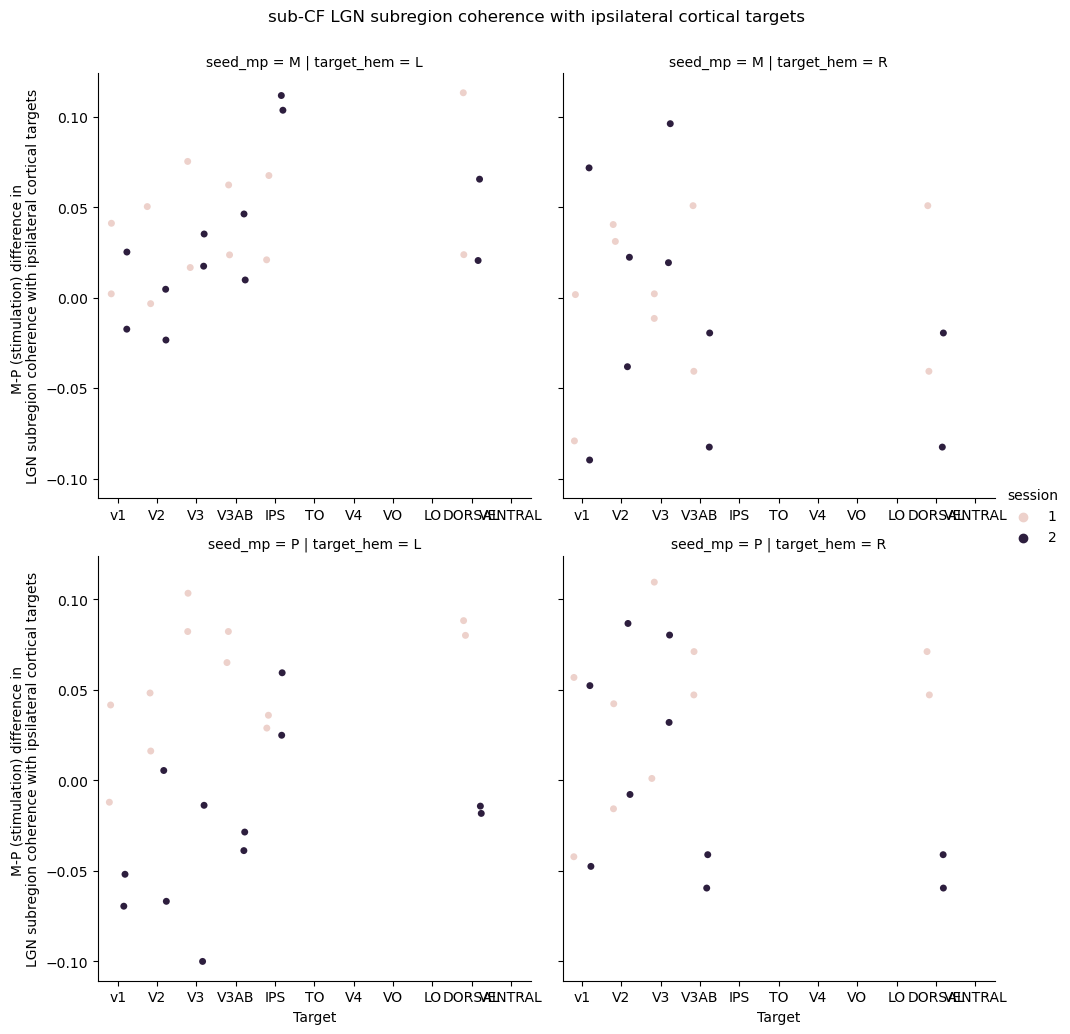

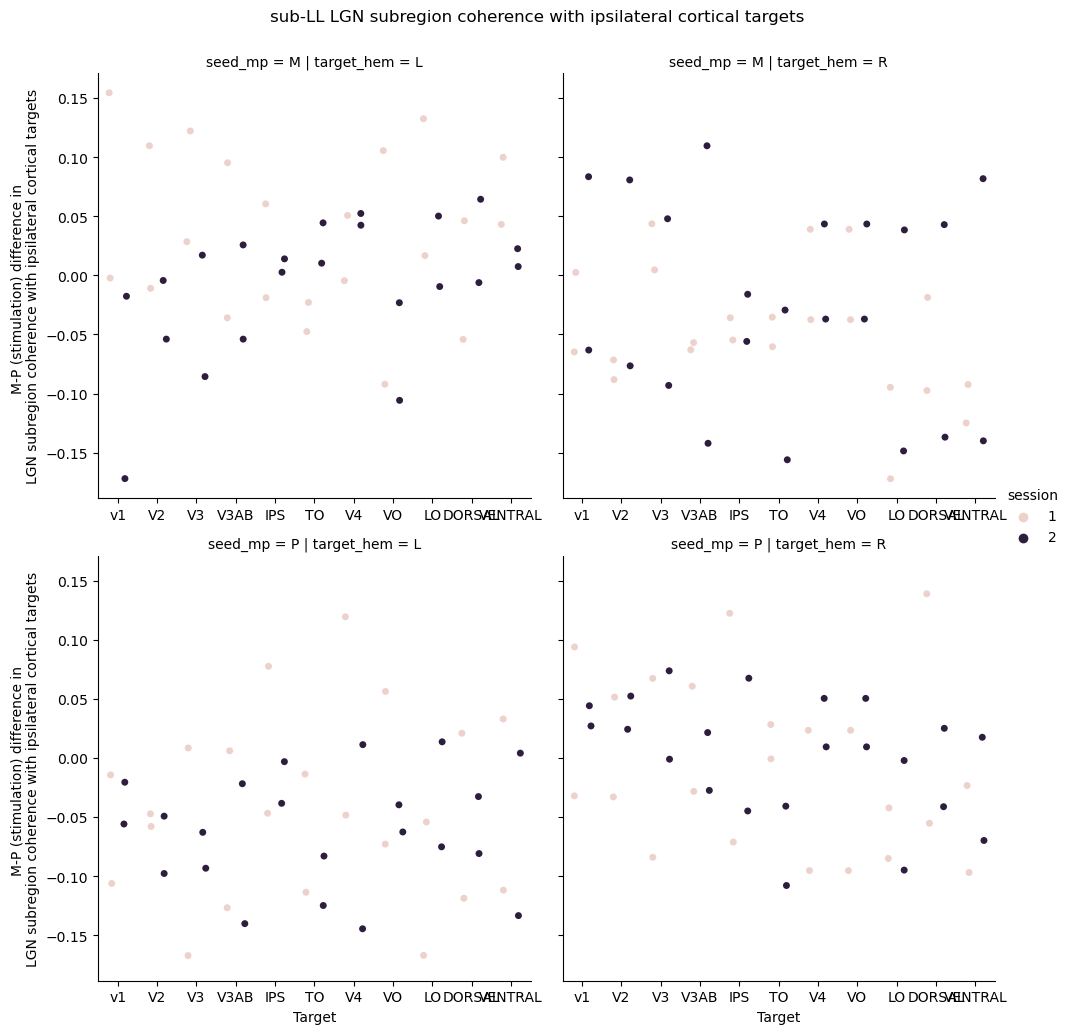

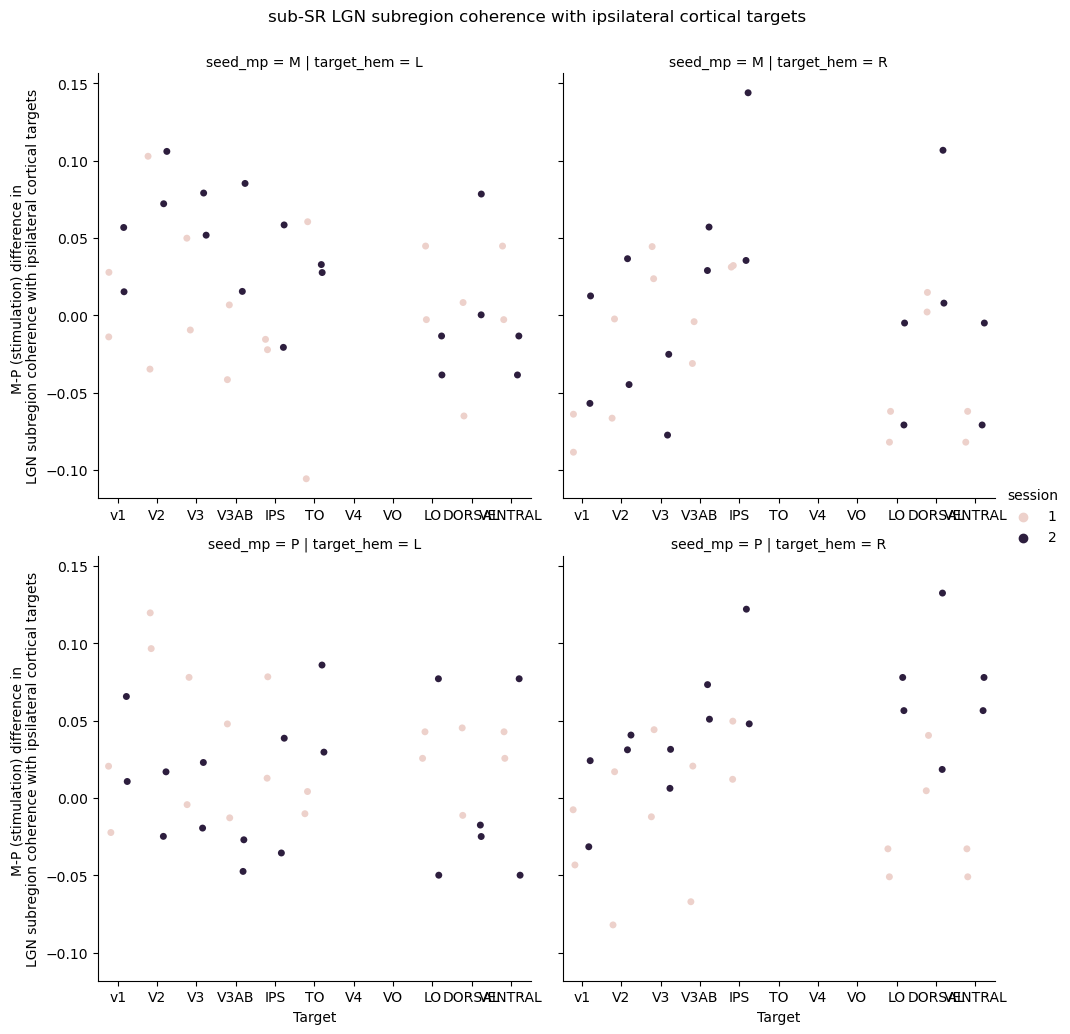

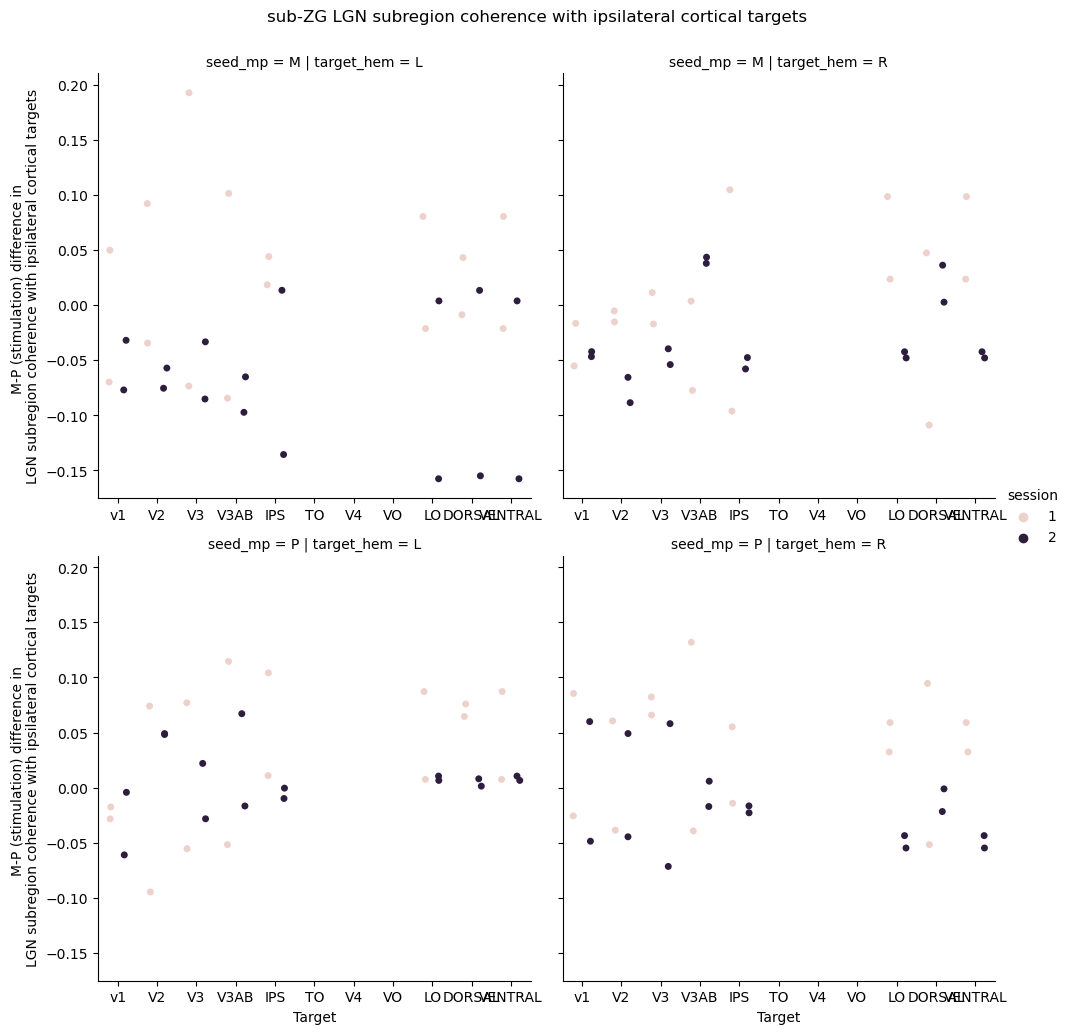

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gv, g in mp_diffs.groupby(['subj']):
        #print(g)
        sns.catplot(data=g.reset_index(), kind='strip', x='target_region', y='mp_diff', row='seed_mp',
                    col='target_hem', hue='session', sharex=False, legend=True, ci=None, dodge=True,
                    order=display_order) \
        .set_axis_labels('Target', "M-P (stimulation) difference in \nLGN subregion coherence with ipsilateral cortical targets") \
        .fig.suptitle(f"{gv} LGN subregion coherence with ipsilateral cortical targets", y=1.03)

In [48]:
mp_df = mp_diffs.groupby(mp_contrast_cols, observed=True)['mp_diff'].agg(['mean', 'sem'])
mp_df.columns = mp_df.columns.map(lambda x: f"mp_{x}")
mp_df = mp_df.reset_index()
mp_df_reduced = mp_df[mp_df.target_region.isin(display_regions)].copy()
mp_df_reduced.head()

,subj,seed,target,measurement,seed_hem,seed_region,target_hem,target_region,seed_mp,attend_hem,ipsi_seedtarget,mp_mean,mp_sem
0,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,L,True,0.044387,0.018993
1,sub-BC,LLGNrevisedM90,LDORSAL,coherence,L,LGNrevisedM90,L,DORSAL,M,R,True,0.029601,0.036074
2,sub-BC,LLGNrevisedM90,LIPS,coherence,L,LGNrevisedM90,L,IPS,M,L,True,0.053444,0.020642
3,sub-BC,LLGNrevisedM90,LIPS,coherence,L,LGNrevisedM90,L,IPS,M,R,True,0.019283,0.042441
4,sub-BC,LLGNrevisedM90,LLO,coherence,L,LGNrevisedM90,L,LO,M,L,True,0.042373,0.110244


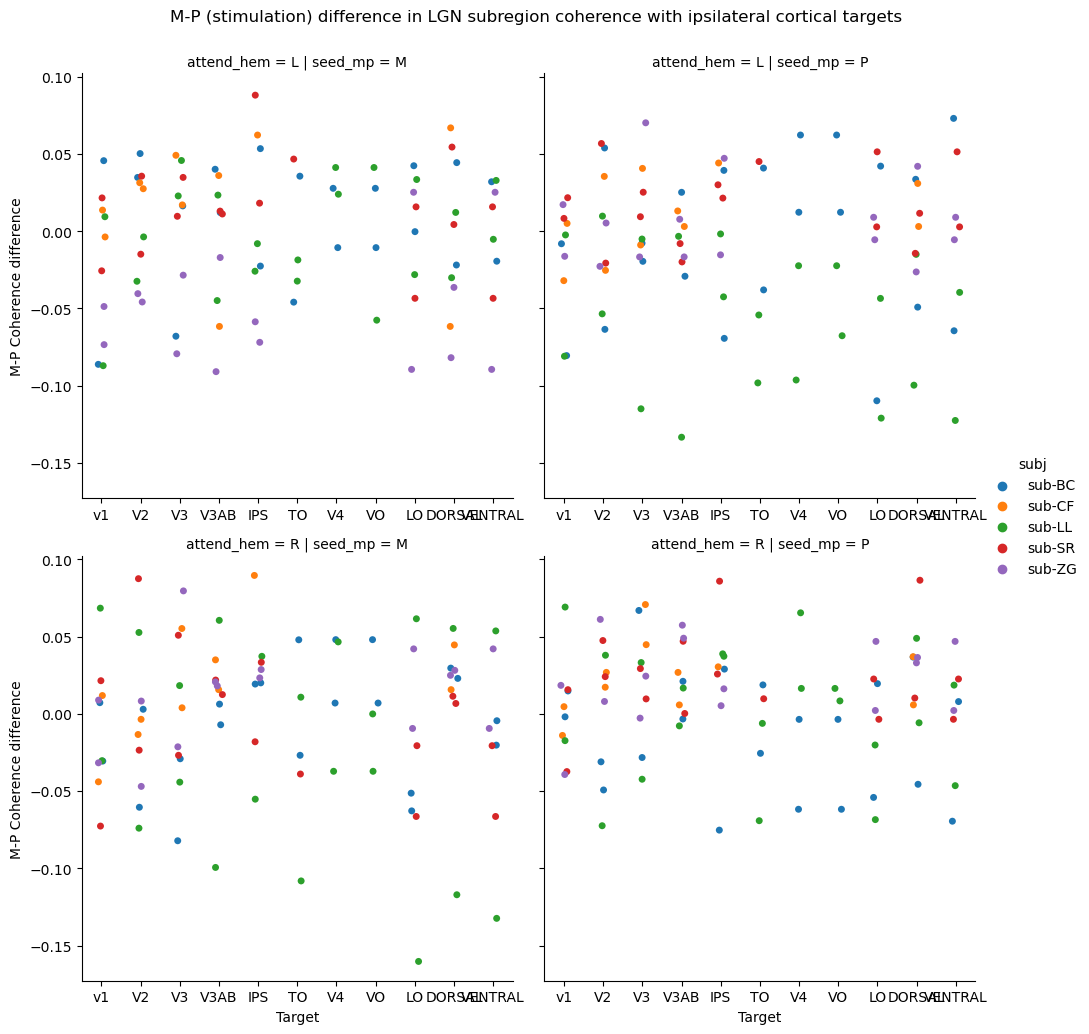

In [49]:
plot_df = mp_df_reduced
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.catplot(data=plot_df, kind='strip', x='target_region', y='mp_mean', hue='subj', col='seed_mp',
                    sharex=False, legend=True, ci=None, order=display_order, row='attend_hem')
    g.set_axis_labels('Target', "M-P Coherence difference") \
    .fig.suptitle("M-P (stimulation) difference in LGN subregion coherence with ipsilateral cortical targets", y=1.03)


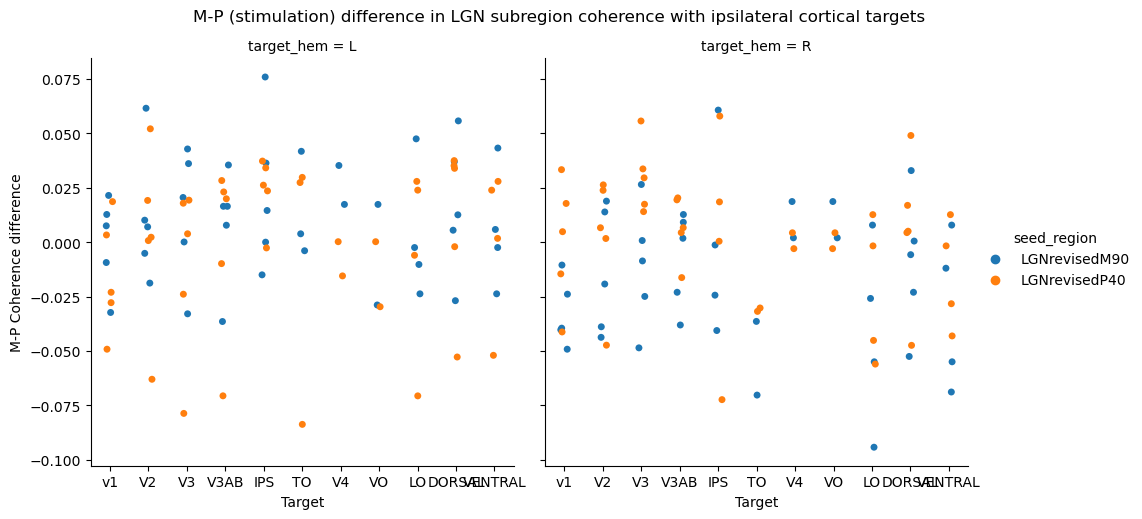

In [50]:
mp_df_xatt = mp_df_reduced.groupby(mp_xatt_cols, observed=True)['mp_mean'].mean().reset_index()
plot_df = mp_df_xatt
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.catplot(data=plot_df, kind='strip', x='target_region', y='mp_mean', hue='seed_region',
                    col='target_hem', sharex=False, legend=True, ci=None, order=display_order) \
        .set_axis_labels('Target', "M-P Coherence difference") \
.fig.suptitle("M-P (stimulation) difference in LGN subregion coherence with ipsilateral cortical targets", y=1.03)


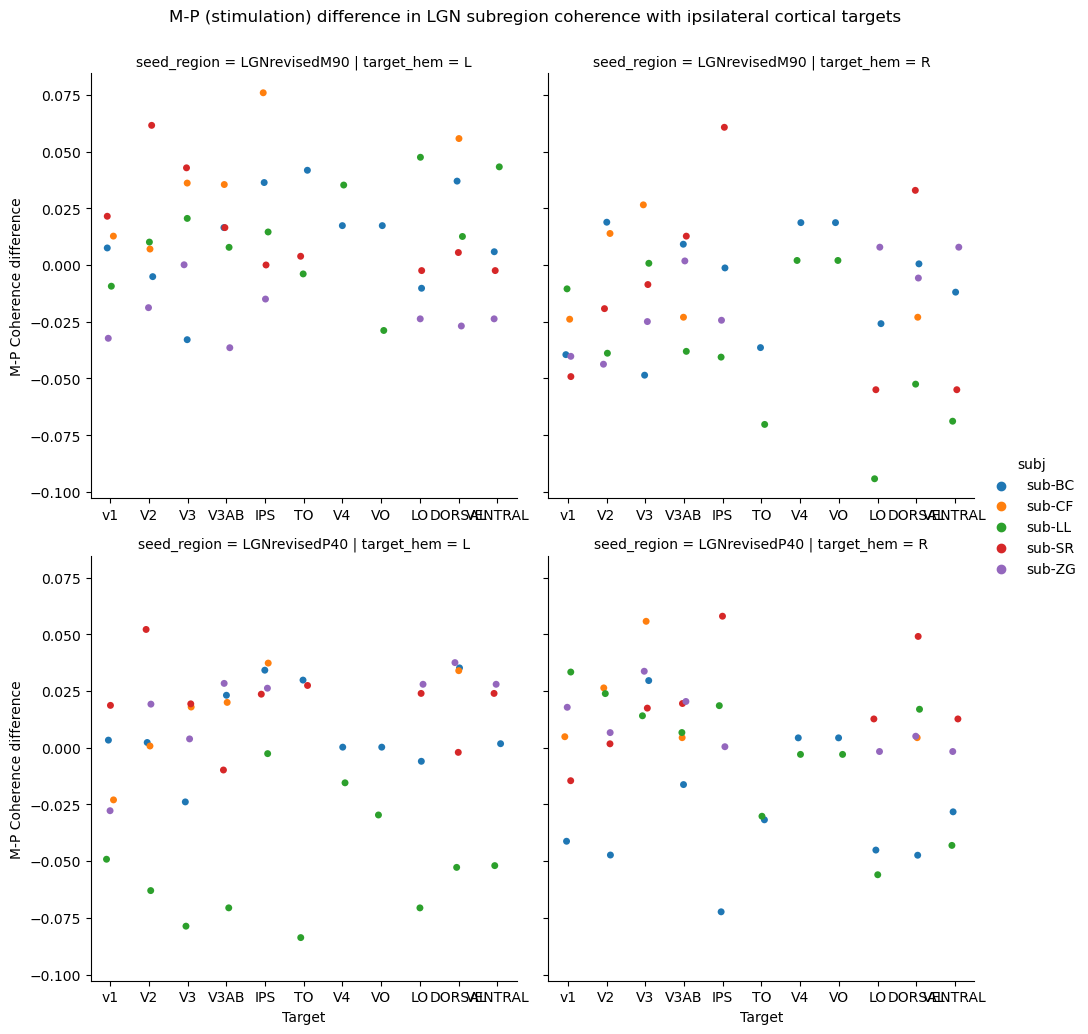

In [51]:
plot_df = mp_df_xatt
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.catplot(data=plot_df, kind='strip', x='target_region', y='mp_mean', hue='subj', row="seed_region",
                    col='target_hem', sharex=False, legend=True, ci=None, order=display_order) \
        .set_axis_labels('Target', "M-P Coherence difference") \
.fig.suptitle("M-P (stimulation) difference in LGN subregion coherence with ipsilateral cortical targets", y=1.03)

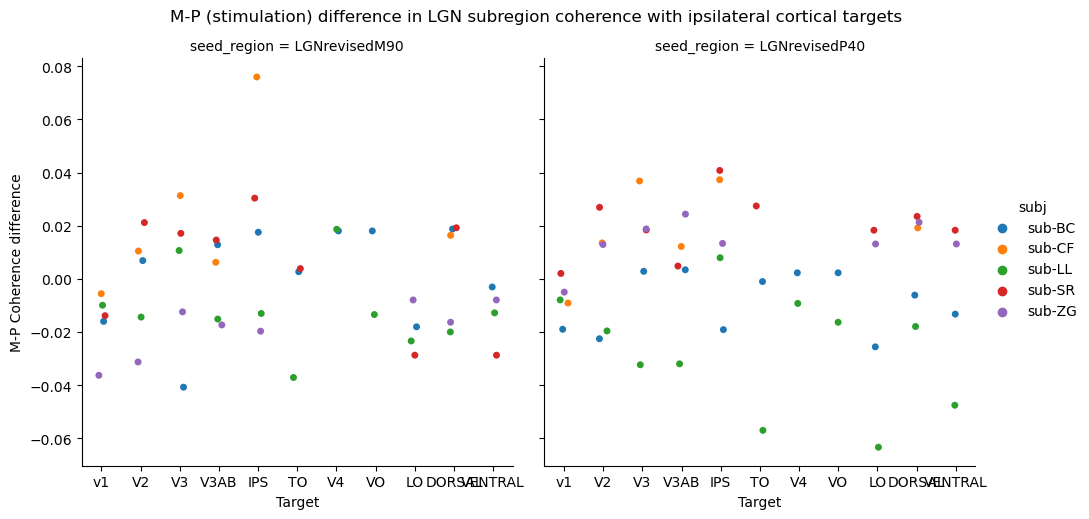

In [52]:
mp_xatt_xhem_df = mp_df_xatt.groupby(
   ['subj','target_region','seed_mp','seed_region'], observed=True)['mp_mean'].mean().reset_index()
plot_df = mp_xatt_xhem_df
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.catplot(data=plot_df, kind='strip', x='target_region', y='mp_mean', hue='subj', col='seed_region',
                    sharex=False, legend=True, ci=None, order=display_order) \
            .set_axis_labels('Target', "M-P Coherence difference") \
            .fig.suptitle("M-P (stimulation) difference in LGN subregion coherence with ipsilateral cortical targets", y=1.03)


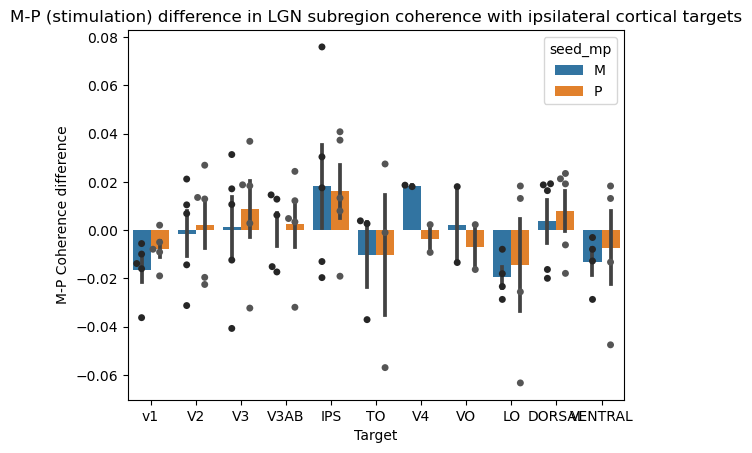

In [53]:
ax = sns.barplot(data=mp_xatt_xhem_df, x='target_region', y='mp_mean', hue="seed_mp", errorbar="se", order=display_order)
ax.set(xlabel='Target', ylabel="M-P Coherence difference")
ax.title.set_text("M-P (stimulation) difference in LGN subregion coherence with ipsilateral cortical targets")
ax = sns.swarmplot(data=mp_xatt_xhem_df, x='target_region', y='mp_mean', hue="seed_mp", ax=ax, dodge=True,
                   palette='dark:#555555', legend=False)

In [54]:
mp_disp = display_order + ['mean']

In [55]:
mp_disp

['v1',
 'V2',
 'V3',
 'V3AB',
 'IPS',
 'TO',
 'V4',
 'VO',
 'LO',
 'DORSAL',
 'VENTRAL',
 'mean']

/tmp/ipykernel_253145/1966897269.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_m = plot_df_m.groupby(['subj']).mean().reset_index()
/tmp/ipykernel_253145/1966897269.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(data=plot_df_m_final, x='target_region', y='mp_mean', ax=ax,


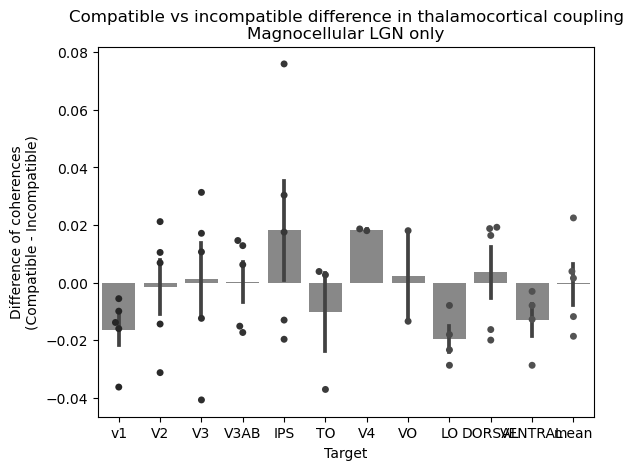

In [56]:
plot_df_m = mp_xatt_xhem_df[mp_xatt_xhem_df.seed_mp=='M']
mean_m = plot_df_m.groupby(['subj']).mean().reset_index()
mean_m['target_region'] = 'mean'
plot_df_m_final = pd.concat((plot_df_m, mean_m)).reset_index()

ax = sns.barplot(data=plot_df_m_final, x='target_region', y='mp_mean', errorbar="se", order=mp_disp,
                 color="#888888")
ax.set(xlabel='Target', ylabel="Difference of coherences\n(Compatible - Incompatible)")
ax.title.set_text("Compatible vs incompatible difference in thalamocortical coupling\nMagnocellular LGN only")
ax = sns.swarmplot(data=plot_df_m_final, x='target_region', y='mp_mean', ax=ax,
                   palette="dark:#555555", legend=False, order=mp_disp)

In [57]:
st.ttest_1samp(plot_df_m_final[plot_df_m_final.target_region=='IPS'].mp_mean, popmean=0)

Ttest_1sampResult(statistic=1.0626527997111126, pvalue=0.34783769665786246)

In [58]:
st.ttest_1samp(plot_df_m_final[plot_df_m_final.target_region=='V3AB'].mp_mean, popmean=0)

Ttest_1sampResult(statistic=0.0368239002373395, pvalue=0.9723898741075869)

In [59]:
st.ttest_1samp(plot_df_m_final[plot_df_m_final.target_region=='DORSAL'].mp_mean, popmean=0)

Ttest_1sampResult(statistic=0.40626761618704443, pvalue=0.7053420318251123)

In [60]:
st.ttest_1samp(plot_df_m_final[plot_df_m_final.target_region=='VENTRAL'].mp_mean, popmean=0)

Ttest_1sampResult(statistic=-2.357029612584019, pvalue=0.09966796531216378)

/tmp/ipykernel_253145/2658743872.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_p = plot_df_p.groupby(['subj']).mean().reset_index()
/tmp/ipykernel_253145/2658743872.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(data=plot_df_p_final, x='target_region', y='mp_mean_rev', ax=ax,


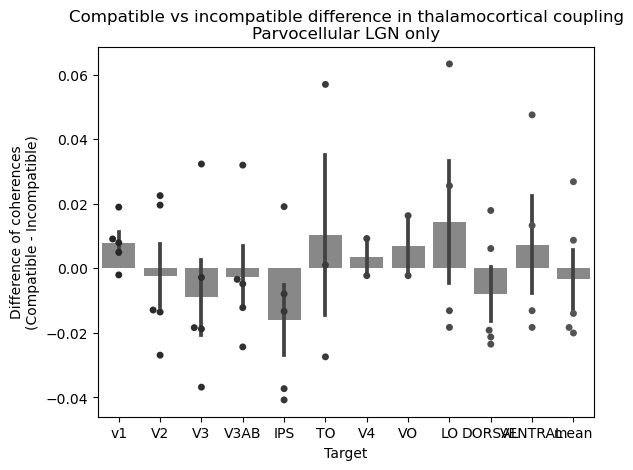

In [61]:
plot_df_p = mp_xatt_xhem_df[mp_xatt_xhem_df.seed_mp=='P'].copy()
mean_p = plot_df_p.groupby(['subj']).mean().reset_index()
mean_p['target_region'] = 'mean'
plot_df_p_final = pd.concat((plot_df_p, mean_p)).reset_index()
plot_df_p_final['mp_mean_rev'] = plot_df_p_final['mp_mean'] * -1

ax = sns.barplot(data=plot_df_p_final, x='target_region', y='mp_mean_rev', errorbar="se", order=mp_disp, color="#888888")
ax.set(xlabel='Target', ylabel="Difference of coherences\n(Compatible - Incompatible)")
ax.title.set_text("Compatible vs incompatible difference in thalamocortical coupling\nParvocellular LGN only")
ax = sns.swarmplot(data=plot_df_p_final, x='target_region', y='mp_mean_rev', ax=ax,
                   palette="dark:#555555", legend=False, order=mp_disp)

In [62]:
st.ttest_1samp(plot_df_p_final[plot_df_p_final.target_region=='IPS'].mp_mean, popmean=0)

Ttest_1sampResult(statistic=1.4743497225358715, pvalue=0.21440167082569453)

In [63]:
st.ttest_1samp(plot_df_p_final[plot_df_p_final.target_region=='DORSAL'].mp_mean, popmean=0)

Ttest_1sampResult(statistic=0.9505579319631391, pvalue=0.3956557051227808)

In [64]:
st.ttest_1samp(plot_df_p_final[plot_df_p_final.target_region=='VENTRAL'].mp_mean, popmean=0)

Ttest_1sampResult(statistic=-0.4867933662124468, pvalue=0.6597535490011585)

In [65]:
st.ttest_1samp(plot_df_p_final[plot_df_p_final.target_region=='TO'].mp_mean, popmean=0)

Ttest_1sampResult(statistic=-0.41061111010997575, pvalue=0.7211691511815193)

## 2 panel plot

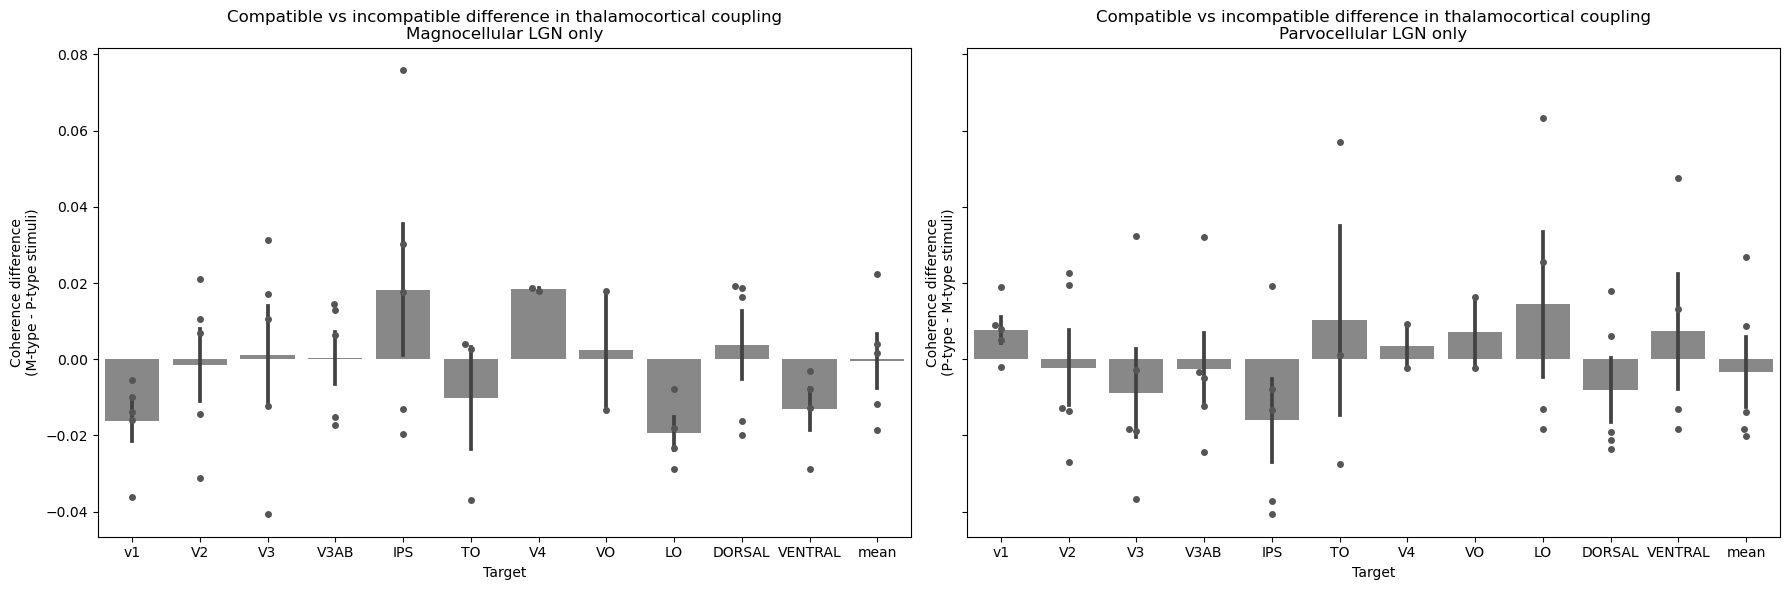

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.barplot(data=plot_df_m_final, x='target_region', y='mp_mean', errorbar="se", order=mp_disp,
            color="#888888", ax=axs[0])
axs[0].set(xlabel='Target', ylabel="Coherence difference\n(M-type - P-type stimuli)")
axs[0].title.set_text("Compatible vs incompatible difference in thalamocortical coupling\nMagnocellular LGN only")
axs[0] = sns.swarmplot(data=plot_df_m_final, x='target_region', y='mp_mean', ax=axs[0],
                   color="#555555", legend=False, order=mp_disp)

sns.barplot(data=plot_df_p_final, x='target_region', y='mp_mean_rev', errorbar="se", order=mp_disp,
            color="#888888", ax=axs[1])
axs[1].set(xlabel='Target', ylabel="Coherence difference\n(P-type - M-type stimuli)")
axs[1].title.set_text("Compatible vs incompatible difference in thalamocortical coupling\nParvocellular LGN only")
axs[1] = sns.swarmplot(data=plot_df_p_final, x='target_region', y='mp_mean_rev', ax=axs[1],
                   color="#555555", legend=False, order=mp_disp)

plt.tight_layout()

plt.show(fig)
plt.close('all')

In [67]:
mp_xseed_groups = mp_df_reduced.groupby(mp_xseed_cols, observed=True)
mp_xseed_diffs = mp_xseed_groups.apply(mp_seed_diff).reset_index()

In [68]:
mp_xatt_xseed_df = mp_xseed_diffs.groupby(
    list(set(mp_xseed_cols).difference(['attend_hem'])), observed=True)['mp_seed_diff'].mean().reset_index()
mp_xatt_xseed_xhem_df = mp_xatt_xseed_df

In [69]:
mp_xseed_cols

['measurement',
 'target_hem',
 'attend_hem',
 'target_region',
 'target',
 'ipsi_seedtarget',
 'subj']

In [70]:
mp_xatt_xseed_xhem_df = mp_xatt_xseed_df.groupby(
    ['subj','target_region'], observed=True)['mp_seed_diff'].mean().reset_index()

In [71]:
mp_xatt_xseed_xhem_df

,subj,target_region,mp_seed_diff
0,sub-BC,v1,0.002970
1,sub-BC,V2,0.029391
2,sub-BC,V3,-0.043567
3,sub-BC,V3AB,0.009417
4,sub-BC,IPS,0.036637
5,sub-BC,TO,0.003689
6,sub-BC,V4,0.015747
7,sub-BC,VO,0.015747
8,sub-BC,LO,0.007529
9,sub-BC,DORSAL,0.024872


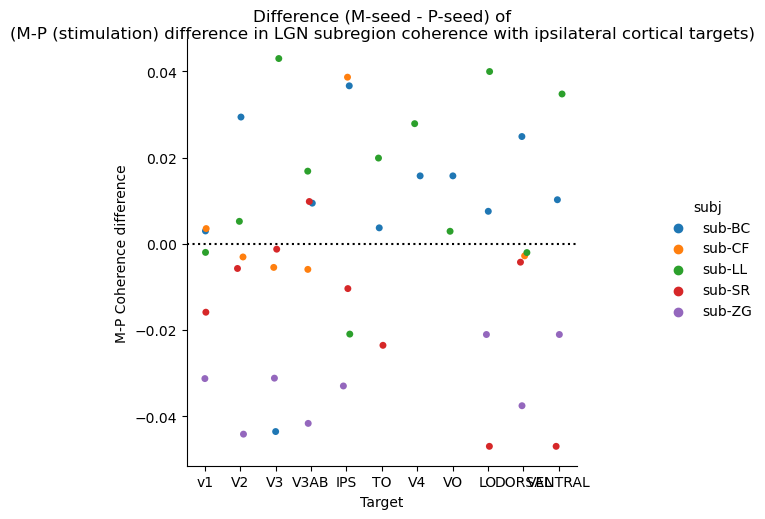

In [72]:
plot_df = mp_xatt_xseed_xhem_df
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.catplot(data=plot_df, kind='strip', x='target_region', y='mp_seed_diff', hue='subj',
                    sharex=False, legend=True, ci=None, order=display_order)
    g.set_axis_labels('Target', "M-P Coherence difference") \
            .fig.suptitle("Difference (M-seed - P-seed) of\n(M-P (stimulation) difference in LGN subregion coherence with ipsilateral cortical targets)", y=1.03)
    g.ax.axhline(y=0, linestyle='dotted', color='black')


In [73]:
mp_final_mean = mp_xatt_xseed_xhem_df.groupby(['subj']).mean().reset_index()
mp_final_mean['target_region'] = 'mean'
mp_plot_df = pd.concat((mp_xatt_xseed_xhem_df, mp_final_mean)).reset_index()
mp_plot_df

/tmp/ipykernel_253145/4221948660.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mp_final_mean = mp_xatt_xseed_xhem_df.groupby(['subj']).mean().reset_index()


,index,subj,target_region,mp_seed_diff
0,0,sub-BC,v1,0.002970
1,1,sub-BC,V2,0.029391
2,2,sub-BC,V3,-0.043567
3,3,sub-BC,V3AB,0.009417
4,4,sub-BC,IPS,0.036637
5,5,sub-BC,TO,0.003689
6,6,sub-BC,V4,0.015747
7,7,sub-BC,VO,0.015747
8,8,sub-BC,LO,0.007529
9,9,sub-BC,DORSAL,0.024872


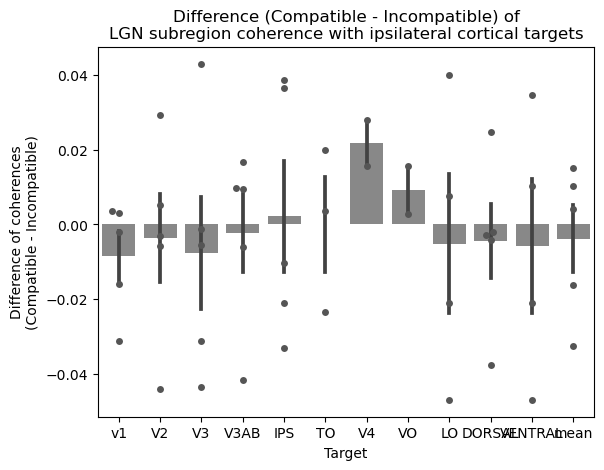

In [74]:
ax = sns.barplot(data=mp_plot_df, x='target_region', y='mp_seed_diff', errorbar="se",
                 order=mp_disp, color="#888888")
ax.set(xlabel='Target', ylabel="Difference of coherences\n(Compatible - Incompatible)")
ax.title.set_text("Difference (Compatible - Incompatible) of\nLGN subregion coherence with ipsilateral cortical targets")
ax = sns.swarmplot(data=mp_plot_df, x='target_region', y='mp_seed_diff', ax=ax, dodge=True, order=mp_disp,
                   color="#555555", legend=False)

In [75]:
def tt(df, col='mp_seed_diff'):
    print(st.ttest_1samp(df[col], popmean=0))

for gv, g in mp_plot_df.groupby(['target_region'], observed=True):
    print(gv, tt(g))

Ttest_1sampResult(statistic=-0.440438375495869, pvalue=0.6823748302908357)
DORSAL None
Ttest_1sampResult(statistic=0.14649668297201834, pvalue=0.8906159870315966)
IPS None
Ttest_1sampResult(statistic=-0.2749097916740131, pvalue=0.8012312031569333)
LO None
Ttest_1sampResult(statistic=0.00013427545385008018, pvalue=0.9999050529164637)
TO None
Ttest_1sampResult(statistic=-0.3098399540232679, pvalue=0.7721534872777587)
V2 None
Ttest_1sampResult(statistic=-0.5165046282308448, pvalue=0.632744306213757)
V3 None
Ttest_1sampResult(statistic=-0.21987110368217072, pvalue=0.8367366929564155)
V3AB None
Ttest_1sampResult(statistic=3.6007438809661036, pvalue=0.1724562053879748)
V4 None
Ttest_1sampResult(statistic=-0.3232590142516127, pvalue=0.7677212757548523)
VENTRAL None
Ttest_1sampResult(statistic=1.4502294946703642, pvalue=0.38431167691711143)
VO None
Ttest_1sampResult(statistic=-0.4331298985612734, pvalue=0.6872534849933611)
mean None
Ttest_1sampResult(statistic=-1.278324100201102, pvalue=0.2702

/tmp/ipykernel_253145/3579368815.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for gv, g in mp_plot_df.groupby(['target_region'], observed=True):


In [76]:
mp_plot_df_40 = pd.read_csv('mp_plot_df_4010_volconstraint.csv')

In [77]:
mp_plot_df_40.loc[mp_plot_df_40.target_region=='V3ABC', 'target_region'] = 'V3AB'

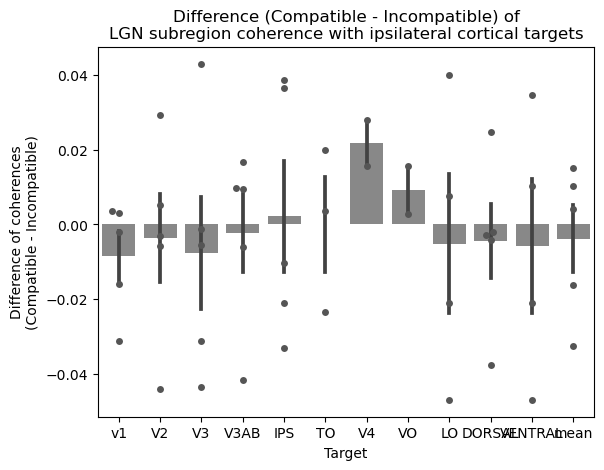

In [78]:
ax = sns.barplot(data=mp_plot_df_40, x='target_region', y='mp_seed_diff', errorbar="se",
                 order=mp_disp, color="#888888")
ax.set(xlabel='Target', ylabel="Difference of coherences\n(Compatible - Incompatible)")
ax.title.set_text("Difference (Compatible - Incompatible) of\nLGN subregion coherence with ipsilateral cortical targets")
ax = sns.swarmplot(data=mp_plot_df_40, x='target_region', y='mp_seed_diff', ax=ax, dodge=True, order=mp_disp,
                   color="#555555", legend=False)

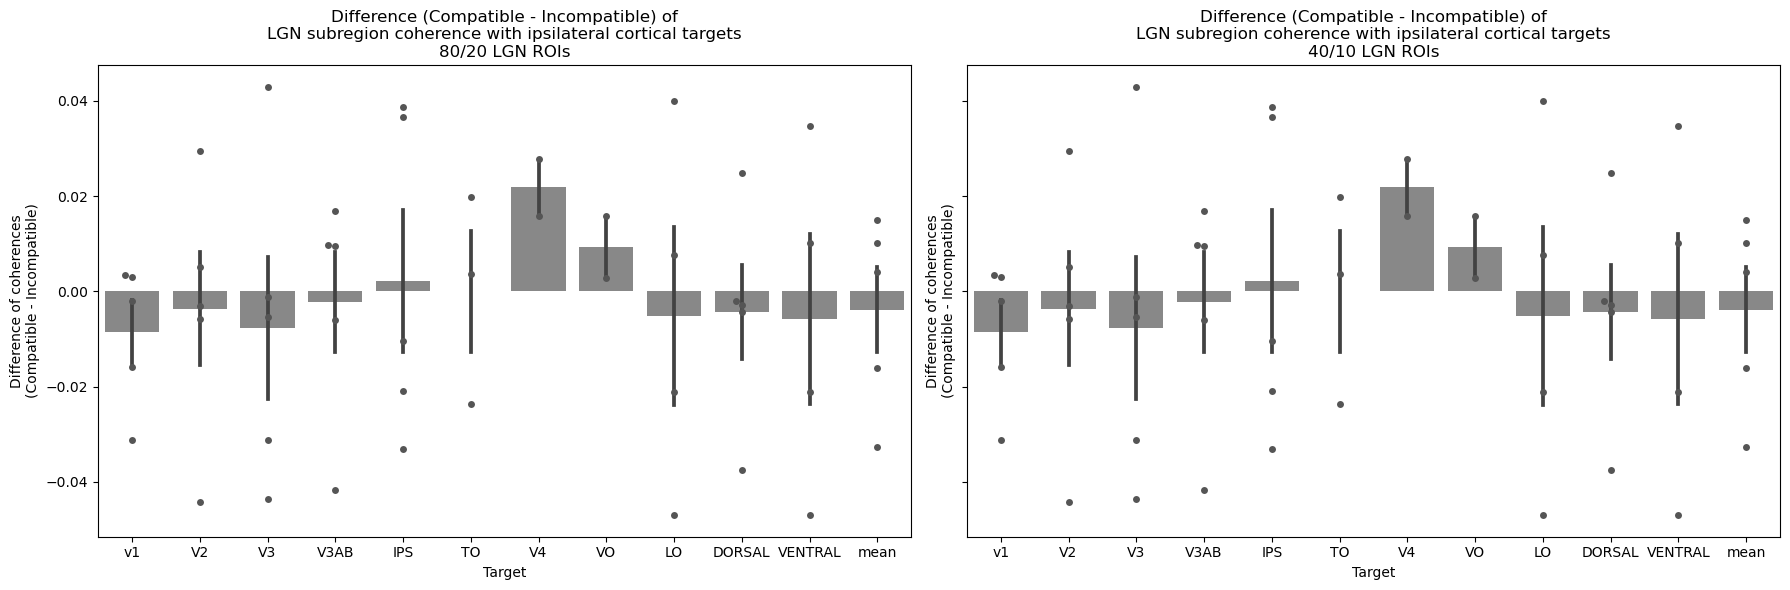

CPU times: user 1.52 s, sys: 1.02 s, total: 2.54 s
Wall time: 1.17 s


In [79]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.barplot(data=mp_plot_df, x='target_region', y='mp_seed_diff', errorbar="se", ax=axs[0],
                 order=mp_disp, color="#888888")
axs[0].set(xlabel='Target', ylabel="Difference of coherences\n(Compatible - Incompatible)")
axs[0].title.set_text("Difference (Compatible - Incompatible) of\nLGN subregion coherence with ipsilateral cortical targets\n80/20 LGN ROIs")
axs[0] = sns.swarmplot(data=mp_plot_df, x='target_region', y='mp_seed_diff', ax=axs[0], dodge=True, order=mp_disp,
                   color="#555555", legend=False)

sns.barplot(data=mp_plot_df_40, x='target_region', y='mp_seed_diff', errorbar="se", ax=axs[1],
                 order=mp_disp, color="#888888")
axs[1].set(xlabel='Target', ylabel="Difference of coherences\n(Compatible - Incompatible)")
axs[1].title.set_text("Difference (Compatible - Incompatible) of\nLGN subregion coherence with ipsilateral cortical targets\n40/10 LGN ROIs")
axs[1] = sns.swarmplot(data=mp_plot_df_40, x='target_region', y='mp_seed_diff', ax=axs[1], dodge=True,
                       order=mp_disp, color="#555555", legend=False)

plt.tight_layout()

plt.show(fig)
plt.close('all')